In [1]:
# import modules
import pandas as pd
import numpy as np
import os
from openpyxl import load_workbook
from pathlib import Path

from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb

import warnings

warnings.filterwarnings("ignore", message="DrawingML support is incomplete")

# Work on Crime and Clearances, and Pop and Area (Compeleted)

In [2]:
# DataFrame for Crimes and clearances with Arson
crime_clearance_df = pd.read_csv(
    "../data/Crimes_and_Clearances_with_Arson-1985-2023.csv"
)

C:\Users\deepe\AppData\Local\Temp\ipykernel_41692\1413198914.py:2: DtypeWarning: Columns (21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_clearance_df = pd.read_csv(


The message above indicates that some of the columns have mixed data type. We can resolve this below:
- First check which columns have non-numeric data types.
- Check which columns have mixed data types. 

In [3]:
## Columns with Non numeric dtypes
non_numeric_cols = crime_clearance_df.select_dtypes(include=["object"]).columns
print(non_numeric_cols)

Index(['County', 'NCICCode', 'TotalStructural_sum', 'TotalMobile_sum',
       'TotalOther_sum', 'GrandTotal_sum', 'GrandTotClr_sum'],
      dtype='object')


In [4]:
def mixed_type_columns(df: pd.DataFrame) -> list:
    """
    Look for columns with mixed types

    Parameters:
    df(pd.DataFrame)

    Returns:
    list: A list of columes with mixed dtypes
    """
    mixed_columns = []
    for column in df.columns:
        types_in_column = df[column].map(type).unique()
        if len(types_in_column) > 1:
            mixed_columns.append(column)
    return mixed_columns

In [5]:
# The columns with mixed dtypes
mixed_columns = mixed_type_columns(crime_clearance_df)
print(mixed_columns)

['TotalStructural_sum', 'TotalMobile_sum', 'TotalOther_sum', 'GrandTotal_sum', 'GrandTotClr_sum']


In [6]:
cca_df = crime_clearance_df.copy()  # A copy of crime_clearance_df

# Resolve the issue with mixed dtypes
cca_df[mixed_columns] = cca_df[mixed_columns].apply(pd.to_numeric, errors="coerce")

In [7]:
# No mixed types in the copy of the dataframe.
mixed_columns = mixed_type_columns(cca_df)
print(mixed_columns == [])

True


In [8]:
# Remove the column
cca_df = cca_df.drop(["NCICCode"], axis=1)
cca_df.head(3)

,Year,County,Violent_sum,Homicide_sum,ForRape_sum,Robbery_sum,AggAssault_sum,Property_sum,Burglary_sum,VehicleTheft_sum,...,MVPLARnao_sum,BILARnao_sum,FBLARnao_sum,COMLARnao_sum,AOLARnao_sum,LT400nao_sum,LT200400nao_sum,LT200nao_sum,LT50200nao_sum,LT50nao_sum
0,1985,Alameda County,427,3,27,166,231,3964,1483,353,...,109,205,44,11,475,753.0,437.0,NaN,440,498
1,1985,Alameda County,405,7,15,220,163,4486,989,260,...,673,516,183,53,559,540.0,622.0,NaN,916,1159
2,1985,Alameda County,101,1,4,58,38,634,161,55,...,62,39,46,17,37,84.0,68.0,NaN,128,138


In [9]:
# Custom function to remove County from the values in the column County
def remove_county(text: str) -> str:
    """
    Remove County from string
    """
    return text.replace(" County", "")


assert remove_county("Hello County") == "Hello"
assert remove_county("Hello World County") == "Hello World"

In [10]:
# Apply the remove_county to the dataframe cca_df
cca_df["County"] = cca_df["County"].apply(remove_county)
cca_df["Year"] = cca_df["Year"].astype(str)

# Group by 'County' and 'Year'
cca_grouped_df = cca_df.groupby(["County", "Year"]).sum()

In [11]:
cca_grouped_df.head(3)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   

              AggAssault_sum  Property_sum  Burglary_sum  VehicleTheft_sum  \
County  Year                                                                 
Alameda 1985            5267         89297         24997              7142   
        1986            5530         90167         24392              7896   
        1987            5767         88306         22399              8909   

              LTtotal_sum  ViolentClr_sum  ...  MVPLARnao_sum  BILARnao_sum  \
County  Year                               ...                                
Alameda 1985        57158            5429  ...           5728          3926   
        1986        57879            5570  ...           5449          3380   
        1987        56998            6303  ...           5445          2954   

              FBLARnao_sum  COMLARnao_sum  AOLARnao_sum  LT400nao_sum  \
County  Year                                                            
Alameda 1985         10664            406          9163        7744.0   
        1986          9575            465          9552        9048.0   
        1987          8687            256          8817       11437.0   

              LT200400nao_sum  LT200nao_sum  LT50200nao_sum  LT50nao_sum  
County  Year                                                              
Alameda 1985           7787.0           0.0           14473        27154  
        1986           7482.0           0.0           13459        27890  
        1987           8132.0           0.0           10845        26584  

[3 rows x 67 columns]

In [12]:
# Create a new feature 'crime_rate' for each county and year: crime_rate = Violentsum/poplation
violent = [
    "Violent_sum",
    "Homicide_sum",
    "ForRape_sum",
    "Robbery_sum",
    "AggAssault_sum",
    "ViolentClr_sum",
    "HomicideClr_sum",
    "ForRapeClr_sum",
    "RobberyClr_sum",
    "AggAssaultClr_sum",
]

property = [
    "Property_sum",
    "Burglary_sum",
    "VehicleTheft_sum",
    "LTtotal_sum",
    "PropertyClr_sum",
    "BurglaryClr_sum",
    "VehicleTheftClr_sum",
    "LTtotalClr_sum",
]

In [13]:
crime_data = cca_grouped_df[violent + property]
crime_data.head()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   

              RobberyClr_sum  AggAssaultClr_sum  Property_sum  Burglary_sum  \
County  Year                                                                  
Alameda 1985            1517               3376         89297         24997   
        1986            1545               3379         90167         24392   
        1987            1569               4132         88306         22399   
        1988            1545               3565         92745         22308   
        1989            1496               3203         92888         21311   

              VehicleTheft_sum  LTtotal_sum  PropertyClr_sum  BurglaryClr_sum  \
County  Year                                                                    
Alameda 1985              7142        57158            15409             3117   
        1986              7896        57879            15121             2899   
        1987              8909        56998            16380             2848   
        1988             11080        59357            16747             2671   
        1989             12556        59021            16171             2539   

              VehicleTheftClr_sum  LTtotalClr_sum  
County  Year                                       
Alameda 1985                 1607           10685  
        1986                 1698           10524  
        1987                 2189           11343  
        1988                 2533           11543  
        1989                 2560           11072

In [14]:
# DataFrame for Pop and area by county
pop_area = pd.read_csv("../data/Pop_and_area_by_county_1980_to_2024.csv")

In [15]:
pop_area = pop_area.rename(columns={"COUNTY": "County", "Area (sq mi)": "Area_sq_mi"})
pop_area_copy = pop_area.copy()  # Make a copy
pop_area_copy.head(3)

,County,Area_sq_mi,1981,1982,1983,1984,1985,1986,1987,1988,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Alameda,738.0,"1,117,800","1,134,000","1,151,800","1,170,400","1,185,500","1,206,900","1,220,600","1,242,300",...,"1,622,205","1,641,983","1,656,919","1,666,247","1,675,964","1,681,337","1,655,767","1,645,265","1,644,199","1,644,569"
1,Alpine,739.0,"1,090","1,100","1,120","1,080","1,100","1,140","1,130","1,100",...,"1,190","1,196","1,201","1,205","1,201","1,204","1,181","1,177","1,166","1,163"
2,Amador,606.0,"19,800","20,250","20,600","21,050","21,800","22,450","23,300","25,750",...,"37,453","37,663","38,807","39,708","40,227","40,426","40,224","40,073","40,028","39,893"


In [16]:
pop_area_copy = pop_area_copy.drop(["Area_sq_mi"], axis=1)
pop_area_copy["County"] = pop_area_copy["County"].apply(lambda x: str(x.strip()))
pop_area_copy.head()

,County,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Alameda,"1,117,800","1,134,000","1,151,800","1,170,400","1,185,500","1,206,900","1,220,600","1,242,300","1,261,200",...,"1,622,205","1,641,983","1,656,919","1,666,247","1,675,964","1,681,337","1,655,767","1,645,265","1,644,199","1,644,569"
1,Alpine,"1,090","1,100","1,120","1,080","1,100","1,140","1,130","1,100","1,090",...,"1,190","1,196","1,201","1,205","1,201","1,204","1,181","1,177","1,166","1,163"
2,Amador,"19,800","20,250","20,600","21,050","21,800","22,450","23,300","25,750","27,600",...,"37,453","37,663","38,807","39,708","40,227","40,426","40,224","40,073","40,028","39,893"
3,Butte,"146,800","150,700","153,800","156,600","159,700","163,000","166,200","170,800","175,200",...,"227,400","228,198","230,412","231,774","227,263","216,090","206,058","206,183","205,741","206,194"
4,Calaveras,"21,350","22,250","23,200","23,850","24,650","25,550","26,800","28,200","29,700",...,"45,395","45,402","45,355","45,367","45,324","45,290","45,013","44,771","44,616","44,436"


In [17]:
# Convert pop_area_copy to the structure of crime_data
pop_index_county = pop_area_copy.set_index("County")  # Index dataframe by County
pop_stacked = pop_index_county.stack().to_frame(name="popupation")
pop_stacked["popupation"] = pop_stacked["popupation"].apply(
    lambda x: int(str(x.replace(",", "")))
)
pop_stacked.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2596 entries, ('Alameda', '1981') to ('State Total', '2024')
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   popupation  2596 non-null   int64
dtypes: int64(1)
memory usage: 29.3+ KB


In [18]:
# Create Column for Population and Area_sq

crime_data_df = crime_data.copy()
crime_data_df["Population"] = pop_stacked[
    "popupation"
]  # Add column 'Population' to crime_data_df

area_df = pop_area.copy()
area_df = area_df[["County", "Area_sq_mi"]]
area_df["County"] = area_df["County"].apply(lambda x: str(x.strip()))

crime_data_df = crime_data_df.reset_index()  # Reset the index
crime_data_df = crime_data_df.merge(area_df, on="County", how="left")
crime_data_df = crime_data_df.set_index(["County", "Year"])

In [19]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  Property_sum  Burglary_sum  \
County Year                                                                  
Yuba   2019              13                107          1844           405   
       2020              26                128          1841           318   
       2021              21                112          1284           242   
       2022              18                 92          1227           302   
       2023              14                 93           828           264   

             VehicleTheft_sum  LTtotal_sum  PropertyClr_sum  BurglaryClr_sum  \
County Year                                                                    
Yuba   2019               475          964              121               45   
       2020               623          900              101               31   
       2021               293          749              110               28   
       2022               131          794               84               19   
       2023               144          420               88               35   

             VehicleTheftClr_sum  LTtotalClr_sum  Population  Area_sq_mi  
County Year                                                               
Yuba   2019                   15              61       79619       630.0  
       2020                   23              47       81178       630.0  
       2021                   42              40       82091       630.0  
       2022                   25              40       82563       630.0  
       2023                   16              37       83405       630.0

In [20]:
crime_data_df.loc[("Yuba", "2021")]

Violent_sum              354.0
Homicide_sum               6.0
ForRape_sum               35.0
Robbery_sum               70.0
AggAssault_sum           243.0
ViolentClr_sum           149.0
HomicideClr_sum            7.0
ForRapeClr_sum             9.0
RobberyClr_sum            21.0
AggAssaultClr_sum        112.0
Property_sum            1284.0
Burglary_sum             242.0
VehicleTheft_sum         293.0
LTtotal_sum              749.0
PropertyClr_sum          110.0
BurglaryClr_sum           28.0
VehicleTheftClr_sum       42.0
LTtotalClr_sum            40.0
Population             82091.0
Area_sq_mi               630.0
Name: (Yuba, 2021), dtype: float64

# Work on Unemployment (Completed)

In [21]:
# DataFrame for Unemployment rate
unemployment_rate_df = pd.read_excel("../data/Unemployment_rate_1990-2023.xlsx")

In [22]:
unemployment_rate_df = unemployment_rate_df.rename(
    columns={
        "County Name/State Abbreviation": "County",
        "unemployment rate(%)": "unemployment_rate",
    }
)
unemployment_rate_df.head()

,Code,Code.1,Code.2,County,Year,Unnamed: 5,Laber Force,Employed,Unemployed,unemployment_rate
0,CN0600100000000,6,1,"Alameda County, CA",2023,NaN,826102,792439,33663,4.1
1,CN0600300000000,6,3,"Alpine County, CA",2023,NaN,540,505,35,6.5
2,CN0600500000000,6,5,"Amador County, CA",2023,NaN,14404,13673,731,5.1
3,CN0600700000000,6,7,"Butte County, CA",2023,NaN,91910,87088,4822,5.2
4,CN0600900000000,6,9,"Calaveras County, CA",2023,NaN,21956,21030,926,4.2


In [23]:
unemployment_rate_df["County"] = unemployment_rate_df["County"].apply(
    lambda x: x.replace(" County, CA", "").replace(" County/city, CA", "")
)
unemp_rate_df = unemployment_rate_df.copy()
# unemp_rate_df = unemp_rate_df.fillna(0)
unemp_rate_df = unemp_rate_df[["County", "Year", "unemployment_rate"]]
unemp_rate_df["Year"] = unemp_rate_df["Year"].astype(str)
unemp_rate_df.set_index(["County", "Year"], inplace=True)

In [24]:
unemp_rate_df.tail()

,,unemployment_rate
County,Year,
Tulare,1993,18.2
Tuolumne,1993,11.9
Ventura,1993,9.1
Yolo,1993,8.1
Yuba,1993,17.5


In [25]:
crime_data_df = crime_data_df.merge(
    unemp_rate_df, left_index=True, right_index=True, how="left"
)

In [26]:
crime_data_df.tail(5)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  Burglary_sum  \
County Year                                     ...                 
Yuba   2019              13                107  ...           405   
       2020              26                128  ...           318   
       2021              21                112  ...           242   
       2022              18                 92  ...           302   
       2023              14                 93  ...           264   

             VehicleTheft_sum  LTtotal_sum  PropertyClr_sum  BurglaryClr_sum  \
County Year                                                                    
Yuba   2019               475          964              121               45   
       2020               623          900              101               31   
       2021               293          749              110               28   
       2022               131          794               84               19   
       2023               144          420               88               35   

             VehicleTheftClr_sum  LTtotalClr_sum  Population  Area_sq_mi  \
County Year                                                                
Yuba   2019                   15              61       79619       630.0   
       2020                   23              47       81178       630.0   
       2021                   42              40       82091       630.0   
       2022                   25              40       82563       630.0   
       2023                   16              37       83405       630.0   

             unemployment_rate  
County Year                     
Yuba   2019                6.2  
       2020               10.6  
       2021                8.4  
       2022                5.6  
       2023                6.7  

[5 rows x 21 columns]

# Work on Median household income and CPI (Completed)

In [27]:
# DataFrame for Califonia_CPI
califonia_cpi_df = pd.read_excel("../data/California_CPI_1985_to_2023.xlsx")

# DataFrame for median household income
median_house_income = pd.read_excel("../data/Median_income_2000_and_2009_to_2023.xlsx")

In [28]:
califonia_cpi_df["Year"] = califonia_cpi_df["Year"].astype(str)
median_house_income["Year"] = median_house_income["Year"].astype(str)

In [29]:
median_house_cpi = median_house_income.merge(califonia_cpi_df, on="Year", how="left")
median_house_cpi["County"] = median_house_cpi["County"].apply(
    lambda x: x.replace(" County", "").strip()
)
median_house_cpi = median_house_cpi.rename(
    columns={"Median Household Income": "median_household_income"}
)
median_house_cpi = median_house_cpi.set_index(["County", "Year"])
median_house_cpi["median_household_income"] = median_house_cpi[
    "median_household_income"
].astype("float64")

In [30]:
median_house_cpi.head()

,,median_household_income,CPI
County,Year,,
California,2023,95473.0,331.804
Alameda,2023,119230.0,331.804
Alpine,2023,83265.0,331.804
Amador,2023,80767.0,331.804
Butte,2023,63084.0,331.804


In [31]:
crime_data_df = crime_data_df.merge(
    median_house_cpi, left_index=True, right_index=True, how="left"
)

In [32]:
crime_data_df.head()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   

              RobberyClr_sum  AggAssaultClr_sum  ...  LTtotal_sum  \
County  Year                                     ...                
Alameda 1985            1517               3376  ...        57158   
        1986            1545               3379  ...        57879   
        1987            1569               4132  ...        56998   
        1988            1545               3565  ...        59357   
        1989            1496               3203  ...        59021   

              PropertyClr_sum  BurglaryClr_sum  VehicleTheftClr_sum  \
County  Year                                                          
Alameda 1985            15409             3117                 1607   
        1986            15121             2899                 1698   
        1987            16380             2848                 2189   
        1988            16747             2671                 2533   
        1989            16171             2539                 2560   

              LTtotalClr_sum  Population  Area_sq_mi  unemployment_rate  \
County  Year                                                              
Alameda 1985           10685     1185500       738.0                NaN   
        1986           10524     1206900       738.0                NaN   
        1987           11343     1220600       738.0                NaN   
        1988           11543     1242300       738.0                NaN   
        1989           11072     1261200       738.0                NaN   

              median_household_income  CPI  
County  Year                                
Alameda 1985                      NaN  NaN  
        1986                      NaN  NaN  
        1987                      NaN  NaN  
        1988                      NaN  NaN  
        1989                      NaN  NaN  

[5 rows x 23 columns]

In [33]:
crime_data_df.tail(5)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  LTtotal_sum  \
County Year                                     ...                
Yuba   2019              13                107  ...          964   
       2020              26                128  ...          900   
       2021              21                112  ...          749   
       2022              18                 92  ...          794   
       2023              14                 93  ...          420   

             PropertyClr_sum  BurglaryClr_sum  VehicleTheftClr_sum  \
County Year                                                          
Yuba   2019              121               45                   15   
       2020              101               31                   23   
       2021              110               28                   42   
       2022               84               19                   25   
       2023               88               35                   16   

             LTtotalClr_sum  Population  Area_sq_mi  unemployment_rate  \
County Year                                                              
Yuba   2019              61       79619       630.0                6.2   
       2020              47       81178       630.0               10.6   
       2021              40       82091       630.0                8.4   
       2022              40       82563       630.0                5.6   
       2023              37       83405       630.0                6.7   

             median_household_income      CPI  
County Year                                    
Yuba   2019                  56607.0  280.638  
       2020                  56278.0  285.315  
       2021                  60764.0  297.371  
       2022                  63626.0  319.224  
       2023                  71493.0  331.804  

[5 rows x 23 columns]

# Work on Poverty (Completed)

In [34]:
poverty_rate_df = pd.read_excel("../data/Poverty_rate_2009_2023.xlsx")

In [35]:
poverty_rate_df.head()

,Year,ID,Name,Poverty Universe,Number in Poverty,90% Confidence Interval,Percent in Poverty,90% Confidence Interval.1
0,2023,6000,California,38249913,4597732,"4,546,196 to 4,649,268",12.0,11.9 to 12.1
1,2023,6001,Alameda County,1594026,151872,"138,959 to 164,785",9.5,8.7 to 10.3
2,2023,6003,Alpine County,1136,177,134 to 220,15.6,11.8 to 19.4
3,2023,6005,Amador County,37700,4400,"3,493 to 5,307",11.7,9.3 to 14.1
4,2023,6007,Butte County,203267,40532,"36,792 to 44,272",19.9,18.1 to 21.7


In [36]:
poverty_rate_df["Name"] = poverty_rate_df["Name"].apply(
    lambda x: x.replace(" County", "")
)
poverty_rate_df = poverty_rate_df.rename(
    columns={
        "Name": "County",
        "Poverty Universe": "poverty_universe",
        "Number in Poverty": "number_in_poverty",
        "Percent in Poverty": "poverty_rate",
    }
)
poverty_rate_df["Year"] = poverty_rate_df["Year"].astype(str)
poverty_rate_df.set_index(["County", "Year"], inplace=True)

In [37]:
poverty_rate_df.head()

,,ID,poverty_universe,number_in_poverty,90% Confidence Interval,poverty_rate,90% Confidence Interval.1
County,Year,,,,,,
California,2023,6000,38249913,4597732,"4,546,196 to 4,649,268",12.0,11.9 to 12.1
Alameda,2023,6001,1594026,151872,"138,959 to 164,785",9.5,8.7 to 10.3
Alpine,2023,6003,1136,177,134 to 220,15.6,11.8 to 19.4
Amador,2023,6005,37700,4400,"3,493 to 5,307",11.7,9.3 to 14.1
Butte,2023,6007,203267,40532,"36,792 to 44,272",19.9,18.1 to 21.7


In [ ]:
poverty_rate_df = poverty_rate_df[
    ["poverty_rate"]
]

In [39]:
poverty_rate_df.head()

,,poverty_rate
County,Year,
California,2023,12.0
Alameda,2023,9.5
Alpine,2023,15.6
Amador,2023,11.7
Butte,2023,19.9


In [40]:
crime_data_df = crime_data_df.merge(
    poverty_rate_df, left_index=True, right_index=True, how="left"
)

In [41]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  PropertyClr_sum  \
County Year                                     ...                    
Yuba   2019              13                107  ...              121   
       2020              26                128  ...              101   
       2021              21                112  ...              110   
       2022              18                 92  ...               84   
       2023              14                 93  ...               88   

             BurglaryClr_sum  VehicleTheftClr_sum  LTtotalClr_sum  Population  \
County Year                                                                     
Yuba   2019               45                   15              61       79619   
       2020               31                   23              47       81178   
       2021               28                   42              40       82091   
       2022               19                   25              40       82563   
       2023               35                   16              37       83405   

             Area_sq_mi  unemployment_rate  median_household_income      CPI  \
County Year                                                                    
Yuba   2019       630.0                6.2                  56607.0  280.638   
       2020       630.0               10.6                  56278.0  285.315   
       2021       630.0                8.4                  60764.0  297.371   
       2022       630.0                5.6                  63626.0  319.224   
       2023       630.0                6.7                  71493.0  331.804   

             poverty_rate  
County Year                
Yuba   2019          15.2  
       2020          16.3  
       2021          15.6  
       2022          14.9  
       2023          15.4  

[5 rows x 24 columns]

# Function to unmerge merged cells

In [42]:
def unmerge_to_dataframe(
    file_path: str, sheet_name: str, rows_to_unmerge=None
) -> pd.DataFrame:
    """
    Unmerges merged cells in an Excel sheet, propagates their values,
    and returns the data as a pandas DataFrame.

    Parameters:
        file_path (str): Path to the input Excel file.
        rows_to_unmerge (int): Number of rows to process for unmerging.
                               If None, processes all rows.

    Returns:
        pd.DataFrame: A DataFrame containing the unmerged data.
    """
    try:
        # Load the workbook and active sheet
        workbook = load_workbook(file_path)
        sheet = workbook[sheet_name]

        # Determine rows to process
        max_row = sheet.max_row
        rows_to_process = min(rows_to_unmerge or max_row, max_row)

        # Unmerge cells and propagate values in specified rows
        for merged_cell in list(sheet.merged_cells):
            sheet.unmerge_cells(str(merged_cell))

        for row in sheet.iter_rows(
            min_row=1, max_row=rows_to_process, max_col=sheet.max_column
        ):
            previous_value = None
            for cell in row:
                if cell.value is None:  # Propagate the previous value
                    cell.value = previous_value
                else:
                    previous_value = cell.value

        # Convert the unmerged data into a pandas DataFrame
        data = sheet.iter_rows(values_only=True)
        df = pd.DataFrame(data)

        # Treat the first row as column headers
        headers = df.iloc[0]  # Extract first row for column names
        df = df[1:]  # Remove the header row from the data
        df.columns = headers  # Set the extracted headers as column names

        return df

    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")
    except PermissionError:
        raise PermissionError(
            f"Permission denied. Ensure the file '{file_path}' is not open."
        )
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")

# Work on House Ownership data (Completed)

In [43]:
# Combine all files in Extra-HO/Extra

extra_hse_dir = "../data/Extra-HO/Extra"

hse_own_dfs = {}  # Dictionary to store data frames
cols = [
    "Label",
    "Total housing units",
    "Mobile home",
    "Occupied housing units",
    "Vacant housing units",
    "Owner-occupied",
    "Renter-occupied",
    "Average household size of owner-occupied unit",
    "Average household size of renter-occupied unit",
    "35.0 percent or more",
]

# Loop over a list of files in the directory: Extra-HI
for filename in os.listdir(extra_hse_dir):
    # print(filename)
    file_path = os.path.join(extra_hse_dir, filename)
    df = unmerge_to_dataframe(file_path=file_path, sheet_name="Data", rows_to_unmerge=1)
    year = filename.strip("HO_, .xlsx")  # Extract the year from the filename
    year_row = ["Year"] + [year] * (df.shape[1] - 1)  # Create the "Year" row
    df.loc[-1] = year_row  # Add the "Year" row
    df.index = df.index + 1  # Adjust the index
    df = df.sort_index()  # Sort the index so the "Year" row appears first

    trans = df.T
    trans.columns = trans.iloc[0]
    trans = trans[1:]
    trans.index.names = ["County"]
    trans = trans.reset_index()
    trans["County"] = trans["County"].apply(
        lambda x: x.replace(" County, California", "")
    )
    trans = trans.set_index(["County", "Year"])
    trans = trans[trans["Label"].isin(["Estimate", "Percent"])]
    more_35 = trans["35.0 percent or more"]
    trans = trans.loc[:, ~trans.columns.duplicated()]
    trans = trans[cols]
    trans["35.0 percent or more"] = more_35.iloc[:, -1]
    hse_own_dfs[year] = trans

In [44]:
hse_own_dfs["2010"].head()

Label Total housing units Mobile home Occupied housing units  \
County  Year                                                                    
Alameda 2010  Estimate             577,538       7,154                532,026   
        2010   Percent             577,538        1.2%                  92.1%   
Alpine  2010  Estimate               1,794          33                    410   
        2010   Percent               1,794        1.8%                  22.9%   
Amador  2010  Estimate              17,823       1,341                 14,715   

             Vacant housing units Owner-occupied Renter-occupied  \
County  Year                                                       
Alameda 2010               45,512        293,277         238,749   
        2010                 7.9%          55.1%           44.9%   
Alpine  2010                1,384            301             109   
        2010                77.1%          73.4%           26.6%   
Amador  2010                3,108         11,372           3,343   

             Average household size of owner-occupied unit  \
County  Year                                                 
Alameda 2010                                          2.91   
        2010                                           (X)   
Alpine  2010                                          3.06   
        2010                                           (X)   
Amador  2010                                          2.29   

             Average household size of renter-occupied unit  \
County  Year                                                  
Alameda 2010                                           2.49   
        2010                                            (X)   
Alpine  2010                                           2.33   
        2010                                            (X)   
Amador  2010                                           2.35   

             35.0 percent or more  
County  Year                       
Alameda 2010               96,884  
        2010                42.4%  
Alpine  2010                   19  
        2010                31.1%  
Amador  2010                1,368

In [45]:
combine_hse_own = pd.concat(list(hse_own_dfs.values()), join="inner")
combine_hse_own = combine_hse_own.rename(
    columns={
        "Total housing units": "Total_Housing_Units",
        "Mobile home": "Mobile_Home",
        "Occupied housing units": "Occupied_Housing_Units",
        "Vacant housing units": "Vacant_Housing_Units",
        "Owner-occupied": "Owner_Occupied",
        "Renter-occupied": "Renter_Occupied",
        "Average household size of owner-occupied unit": "Avg_Hsehld_Size_Owner_Occupied",
        "Average household size of renter-occupied unit": "Avg_HseHld_Size_Renter_Occupied",
    }
)  # Rename
# combine_hse_own = combine_hse_own.replace('(X)', np.nan)

rent_burden_df = combine_hse_own[combine_hse_own["Label"] == "Percent"][
    ["35.0 percent or more"]
]
combine_hse_own = combine_hse_own[combine_hse_own["Label"] == "Estimate"]

col_to_int = [
    "Mobile_Home",
    "Total_Housing_Units",
    "Vacant_Housing_Units",
    "Owner_Occupied",
    "Renter_Occupied",
    "Occupied_Housing_Units",
]
for val in col_to_int:
    combine_hse_own[val] = combine_hse_own[val].apply(lambda x: int(x.replace(",", "")))

combine_hse_own["Avg_Hsehld_Size_Owner_Occupied"] = combine_hse_own[
    "Avg_Hsehld_Size_Owner_Occupied"
].astype(float)
combine_hse_own["Avg_HseHld_Size_Renter_Occupied"] = combine_hse_own[
    "Avg_HseHld_Size_Renter_Occupied"
].astype(float)

rent_burden_df["35.0 percent or more"] = rent_burden_df["35.0 percent or more"].apply(
    lambda x: (x.replace(",", "")).replace("%", "")
)
rent_burden_df["35.0 percent or more"] = rent_burden_df["35.0 percent or more"].astype(
    float
)

# combine_hse_own  = combine_hse_own.drop(['Label'])
combine_hse_own["35.0 percent or more"] = rent_burden_df["35.0 percent or more"]

In [46]:
combine_hse_own.tail()

,,Label,Total_Housing_Units,Mobile_Home,Occupied_Housing_Units,Vacant_Housing_Units,Owner_Occupied,Renter_Occupied,Avg_Hsehld_Size_Owner_Occupied,Avg_HseHld_Size_Renter_Occupied,35.0 percent or more
County,Year,,,,,,,,,,
Tulare,2023,Estimate,152542,9679,142026,10516,83253,58773,3.27,3.36,42.1
Tuolumne,2023,Estimate,31491,2476,22809,8682,16912,5897,2.30,2.14,49.3
Ventura,2023,Estimate,294651,11833,278045,16606,178388,99657,2.97,2.97,48.8
Yolo,2023,Estimate,81543,3450,76640,4903,41046,35594,2.80,2.63,48.2
Yuba,2023,Estimate,30089,2435,28063,2026,17769,10294,3.04,2.68,38.8


In [47]:
crime_data_df = crime_data_df.merge(
    combine_hse_own, left_index=True, right_index=True, how="left"
)

In [48]:
crime_data_df.tail(3)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...     Label  \
County Year                                     ...             
Yuba   2021              21                112  ...  Estimate   
       2022              18                 92  ...  Estimate   
       2023              14                 93  ...  Estimate   

             Total_Housing_Units  Mobile_Home  Occupied_Housing_Units  \
County Year                                                             
Yuba   2021              29152.0       2542.0                 26888.0   
       2022              29626.0       2484.0                 27567.0   
       2023              30089.0       2435.0                 28063.0   

             Vacant_Housing_Units  Owner_Occupied  Renter_Occupied  \
County Year                                                          
Yuba   2021                2264.0         16556.0          10332.0   
       2022                2059.0         16928.0          10639.0   
       2023                2026.0         17769.0          10294.0   

             Avg_Hsehld_Size_Owner_Occupied  Avg_HseHld_Size_Renter_Occupied  \
County Year                                                                    
Yuba   2021                            3.07                             2.73   
       2022                            3.02                             2.73   
       2023                            3.04                             2.68   

             35.0 percent or more  
County Year                        
Yuba   2021                  39.3  
       2022                  39.5  
       2023                  38.8  

[3 rows x 34 columns]

In [49]:
df_35 = pd.read_excel("../data/Median_house_value_2010_to_2023.xlsx")

In [50]:
df_35.head()

,Unnamed: 0,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010
0,Alameda County,"1,057,400","999,200","870,100","825,300","769,300","707,800","649,100","593,500","543,100","509,300","493,800",514900,"558,300","590,900"
1,Alpine County,"466,100","463,900","378,200","372,500","365,300","349,000","343,800","329,500","295,000","313,800","333,600",371300,"395,600","453,600"
2,Amador County,"422,800","409,600","349,500","329,300","313,700","296,400","278,600","265,900","251,000","251,800","270,500",286500,"318,400","341,400"
3,Butte County,"408,700","371,600","325,600","304,700","271,700","248,100","238,200","228,500","221,700","220,100","225,900",237400,"254,900","265,400"
4,Calaveras County,"441,800","404,200","354,600","340,000","319,500","297,700","273,400","259,000","243,800","242,600","254,800",276200,"312,000","350,800"


# Work on Age folder to get the median age. (Completed)

In [51]:
age_dir = "../data/Age"
age_dfs = {}  # Dictionary to store dataframes
cols = [
    "Total_both",
    "Median age (years)",
]
for filename in os.listdir(age_dir):
    # print(filename)
    file_path = os.path.join(age_dir, filename)
    df = unmerge_to_dataframe(file_path=file_path, sheet_name="Data", rows_to_unmerge=1)
    year = filename.strip("Age_, .xlsx")  # Extract the year from the filename
    year_row = ["Year"] + [year] * (df.shape[1] - 1)  # Create the "Year" row
    df.loc[-1] = year_row  # Add the "Year" row
    df.index = df.index + 1  # Adjust the index
    df = df.sort_index()  # Sort the index so the "Year" row appears first

    trans2 = df.T
    trans2.columns = trans2.iloc[0]
    trans2 = trans2[1:]
    trans2.index.names = ["County"]
    trans2 = trans2.reset_index()
    trans2["County"] = trans2["County"].apply(
        lambda x: x.replace(" County, California", "")
    )
    trans2 = trans2.set_index(["County", "Year"])
    trans2 = trans2[trans2["Label"] == "Estimate"]
    trans2 = trans2.rename(columns={"": "Total_both"})
    # trans2 = trans2.loc[:, ~trans2.columns.duplicated()]
    trans2 = trans2[cols]
    # trans2 = trans2[trans2['Sex_Category'].isin(['Male', 'Female'])]
    trans2 = trans2[trans2["Total_both"] == "Total"]
    age_dfs[year] = trans2

### Combine all the age dataframes into one dataframe 

In [52]:
combined_age_dfs = pd.concat(age_dfs.values())
combined_age_dfs.rename(columns={"Median age (years)": "Median_Age"}, inplace=True)
combined_age_dfs = combined_age_dfs[["Median_Age"]]
combined_age_dfs["Median_Age"] = combined_age_dfs["Median_Age"].astype(float)

In [53]:
# Merge with crime_data_df
crime_data_df = crime_data_df.merge(
    combined_age_dfs, left_index=True, right_index=True, how="left"
)

In [54]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  Total_Housing_Units  \
County Year                                     ...                        
Yuba   2019              13                107  ...              28586.0   
       2020              26                128  ...              28632.0   
       2021              21                112  ...              29152.0   
       2022              18                 92  ...              29626.0   
       2023              14                 93  ...              30089.0   

             Mobile_Home  Occupied_Housing_Units  Vacant_Housing_Units  \
County Year                                                              
Yuba   2019       2371.0                 26354.0                2232.0   
       2020       2677.0                 26434.0                2198.0   
       2021       2542.0                 26888.0                2264.0   
       2022       2484.0                 27567.0                2059.0   
       2023       2435.0                 28063.0                2026.0   

             Owner_Occupied  Renter_Occupied  Avg_Hsehld_Size_Owner_Occupied  \
County Year                                                                    
Yuba   2019         15948.0          10406.0                            2.89   
       2020         16089.0          10345.0                            3.00   
       2021         16556.0          10332.0                            3.07   
       2022         16928.0          10639.0                            3.02   
       2023         17769.0          10294.0                            3.04   

             Avg_HseHld_Size_Renter_Occupied  35.0 percent or more  Median_Age  
County Year                                                                     
Yuba   2019                             2.77                  41.5        32.8  
       2020                             2.68                  37.5        33.0  
       2021                             2.73                  39.3        33.2  
       2022                             2.73                  39.5        33.5  
       2023                             2.68                  38.8        33.9  

[5 rows x 35 columns]

In [55]:
crime_data_df.columns

Index(['Violent_sum', 'Homicide_sum', 'ForRape_sum', 'Robbery_sum',
       'AggAssault_sum', 'ViolentClr_sum', 'HomicideClr_sum', 'ForRapeClr_sum',
       'RobberyClr_sum', 'AggAssaultClr_sum', 'Property_sum', 'Burglary_sum',
       'VehicleTheft_sum', 'LTtotal_sum', 'PropertyClr_sum', 'BurglaryClr_sum',
       'VehicleTheftClr_sum', 'LTtotalClr_sum', 'Population', 'Area_sq_mi',
       'unemployment_rate', 'median_household_income', 'CPI', 'poverty_rate',
       'Label', 'Total_Housing_Units', 'Mobile_Home', 'Occupied_Housing_Units',
       'Vacant_Housing_Units', 'Owner_Occupied', 'Renter_Occupied',
       'Avg_Hsehld_Size_Owner_Occupied', 'Avg_HseHld_Size_Renter_Occupied',
       '35.0 percent or more', 'Median_Age'],
      dtype='object')

# Work on Expenditure (Completed)

In [59]:
expenditure_df = pd.read_excel("../data/Expenditure_2003_to_2023.xlsx")
expenditure_df.head(3)

,Entity Name,Entity ID,Fiscal Year,Police Protection_Total Governmental Funds_,Total Education_Total Governmental Funds,Total Public Assistance_Total Governmental Funds,Mental Health_Total Governmental Funds_Health,Drug and Alcohol Abuse Services_Total Governmental Funds_Health,Total Health_Total Governmental Funds,Total Judicial_Total Governmental Funds,Total Detention and Correction_Total Governmental Funds
0,Alameda,1,2023,136000000,39064698.0,1044985620,503588373.0,59132457.0,1100494826,253504410,433901696
1,Alpine,2,2023,3803427,684938.0,3104497,1997691.0,267679.0,3897922,573927,704258
2,Amador,3,2023,13793355,1087355.0,16887389,9895140.0,936709.0,14857378,7175470,9139719


In [60]:
zero_count = (expenditure_df == 0).sum().sum()
print("Total number of zeros:", zero_count)
expenditure_df.replace(0, pd.NA, inplace=True)

Total number of zeros: 71


In [61]:
expenditure_df.columns

Index(['Entity Name', 'Entity ID', 'Fiscal Year',
       'Police Protection_Total Governmental Funds_',
       'Total Education_Total Governmental Funds',
       'Total Public Assistance_Total Governmental Funds',
       'Mental Health_Total Governmental Funds_Health',
       'Drug and Alcohol Abuse Services_Total Governmental Funds_Health',
       'Total Health_Total Governmental Funds',
       'Total Judicial_Total Governmental Funds',
       'Total Detention and Correction_Total Governmental Funds'],
      dtype='object')

In [62]:
expenditure_df = expenditure_df.rename(
    columns={
        "Entity Name": "County",
        "Fiscal Year": "Year",
        "Entity ID": "entity_ID",
        "Police Protection_Total Governmental Funds_": "police_budget",
        "Total Education_Total Governmental Funds": "education_budget",
        "Total Public Assistance_Total Governmental Funds": "welfare_budget",
        "Mental Health_Total Governmental Funds_Health": "mental_health_budget",
        "Drug and Alcohol Abuse Services_Total Governmental Funds_Health": "rehab_budget",
        "Total Health_Total Governmental Funds": "health_budget",
        "Total Judicial_Total Governmental Funds": "judiciary_budget",
        "Total Detention and Correction_Total Governmental Funds": "prison_budget",
    }
)
expenditure_df["Year"] = expenditure_df["Year"].astype(str)

In [63]:
expenditure_df = expenditure_df.set_index(["County", "Year"])

In [64]:
crime_data_df = crime_data_df.merge(
    expenditure_df, left_index=True, right_index=True, how="left"
)

In [65]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  Median_Age  entity_ID  \
County Year                                     ...                          
Yuba   2019              13                107  ...        32.8       58.0   
       2020              26                128  ...        33.0       58.0   
       2021              21                112  ...        33.2       58.0   
       2022              18                 92  ...        33.5       58.0   
       2023              14                 93  ...        33.9       58.0   

             police_budget  education_budget  welfare_budget  \
County Year                                                    
Yuba   2019     14716864.0          751117.0      55383937.0   
       2020     17727927.0          925062.0      61120436.0   
       2021     19675856.0          748989.0      61764264.0   
       2022     20769405.0          877646.0      64768102.0   
       2023     25572041.0         1160708.0      76752736.0   

             mental_health_budget  rehab_budget  health_budget  \
County Year                                                      
Yuba   2019                   NaN           NaN      7392287.0   
       2020                   NaN           NaN      8048817.0   
       2021                   NaN           NaN      8985660.0   
       2022                   NaN           NaN      8170449.0   
       2023                   NaN           NaN     10300301.0   

             judiciary_budget  prison_budget  
County Year                                   
Yuba   2019         7801988.0     28827261.0  
       2020         8387907.0     29604708.0  
       2021         7942027.0     32667592.0  
       2022         8039014.0     34509282.0  
       2023         9040788.0     37616934.0  

[5 rows x 44 columns]

In [334]:
crime_data_df["CPI_Population"] = crime_data_df["CPI"] * crime_data_df["Population"]

In [335]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  entity_ID  police_budget  \
County Year                                     ...                             
Yuba   2019              13                107  ...       58.0     14716864.0   
       2020              26                128  ...       58.0     17727927.0   
       2021              21                112  ...       58.0     19675856.0   
       2022              18                 92  ...       58.0     20769405.0   
       2023              14                 93  ...       58.0     25572041.0   

             education_budget  welfare_budget  mental_health_budget  \
County Year                                                           
Yuba   2019          751117.0      55383937.0                   NaN   
       2020          925062.0      61120436.0                   NaN   
       2021          748989.0      61764264.0                   NaN   
       2022          877646.0      64768102.0                   NaN   
       2023         1160708.0      76752736.0                   NaN   

             rehab_budget  health_budget  judiciary_budget  prison_budget  \
County Year                                                                 
Yuba   2019           NaN      7392287.0         7801988.0     28827261.0   
       2020           NaN      8048817.0         8387907.0     29604708.0   
       2021           NaN      8985660.0         7942027.0     32667592.0   
       2022           NaN      8170449.0         8039014.0     34509282.0   
       2023           NaN     10300301.0         9040788.0     37616934.0   

             CPI_Population  
County Year                  
Yuba   2019    2.234412e+07  
       2020    2.316130e+07  
       2021    2.441148e+07  
       2022    2.635609e+07  
       2023    2.767411e+07  

[5 rows x 47 columns]

# Work on Median House Value (Completed)

In [66]:
median_house_value = pd.read_excel("../data/Median_house_value_2010_to_2023.xlsx")
median_house_value.head(3)

,Unnamed: 0,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010
0,Alameda County,"1,057,400","999,200","870,100","825,300","769,300","707,800","649,100","593,500","543,100","509,300","493,800",514900,"558,300","590,900"
1,Alpine County,"466,100","463,900","378,200","372,500","365,300","349,000","343,800","329,500","295,000","313,800","333,600",371300,"395,600","453,600"
2,Amador County,"422,800","409,600","349,500","329,300","313,700","296,400","278,600","265,900","251,000","251,800","270,500",286500,"318,400","341,400"


In [67]:
median_house_value = median_house_value.rename(columns={"Unnamed: 0": "County"})
median_house_value["County"] = median_house_value["County"].apply(
    lambda x: x.replace(" County", "")
)

In [68]:
median_house_value = median_house_value.set_index("County")

In [69]:
median_house_value = median_house_value.map(
    lambda x: int(x.replace(",", "")) if type(x) == str else x
)
median_house_value_stack = median_house_value.stack().to_frame("median_house_value")

In [70]:
median_house_value_stack.index.names = ["County", "Year"]

In [71]:
median_house_value_stack.reset_index(inplace=True)
median_house_value_stack["Year"] = median_house_value_stack["Year"].astype(str)
median_house_value_stack = median_house_value_stack.set_index(["County", "Year"])

In [72]:
crime_data_df = crime_data_df.merge(
    median_house_value_stack, left_index=True, right_index=True, how="left"
)

# Work on urban, suburban, rural (Completed)

In [74]:
county_category = pd.read_csv("../data/California_County_Categories.csv")
county_category.head()

,County,Category
0,Alameda,Urban
1,Contra Costa,Urban
2,Fresno,Urban
3,Los Angeles,Urban
4,Orange,Urban


In [75]:
county_category.set_index(["County"], inplace=True)

In [76]:
county_category.head()

,Category
County,
Alameda,Urban
Contra Costa,Urban
Fresno,Urban
Los Angeles,Urban
Orange,Urban


In [77]:
crime_data_df = crime_data_df.merge(
    county_category, left_index=True, right_index=True, how="left"
)

In [78]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  police_budget  \
County Year                                     ...                  
Yuba   2019              13                107  ...     14716864.0   
       2020              26                128  ...     17727927.0   
       2021              21                112  ...     19675856.0   
       2022              18                 92  ...     20769405.0   
       2023              14                 93  ...     25572041.0   

             education_budget  welfare_budget  mental_health_budget  \
County Year                                                           
Yuba   2019          751117.0      55383937.0                   NaN   
       2020          925062.0      61120436.0                   NaN   
       2021          748989.0      61764264.0                   NaN   
       2022          877646.0      64768102.0                   NaN   
       2023         1160708.0      76752736.0                   NaN   

             rehab_budget  health_budget  judiciary_budget  prison_budget  \
County Year                                                                 
Yuba   2019           NaN      7392287.0         7801988.0     28827261.0   
       2020           NaN      8048817.0         8387907.0     29604708.0   
       2021           NaN      8985660.0         7942027.0     32667592.0   
       2022           NaN      8170449.0         8039014.0     34509282.0   
       2023           NaN     10300301.0         9040788.0     37616934.0   

             median_house_value  Category  
County Year                                
Yuba   2019            257100.0     Rural  
       2020            273600.0     Rural  
       2021            286000.0     Rural  
       2022            350600.0     Rural  
       2023            380000.0     Rural  

[5 rows x 46 columns]

In [79]:
crime_data_df

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   
...                   ...           ...          ...          ...   
Yuba    2019          326             7           41           61   
        2020          404             2           37           57   
        2021          354             6           35           70   
        2022          279             5           33           40   
        2023          334             9           24           31   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   
...                      ...             ...              ...             ...   
Yuba    2019             217             134                8               6   
        2020             308             161                2               5   
        2021             243             149                7               9   
        2022             201             121                4               7   
        2023             270             122                7               8   

              RobberyClr_sum  AggAssaultClr_sum  ...  police_budget  \
County  Year                                     ...                  
Alameda 1985            1517               3376  ...            NaN   
        1986            1545               3379  ...            NaN   
        1987            1569               4132  ...            NaN   
        1988            1545               3565  ...            NaN   
        1989            1496               3203  ...            NaN   
...                      ...                ...  ...            ...   
Yuba    2019              13                107  ...     14716864.0   
        2020              26                128  ...     17727927.0   
        2021              21                112  ...     19675856.0   
        2022              18                 92  ...     20769405.0   
        2023              14                 93  ...     25572041.0   

              education_budget  welfare_budget  mental_health_budget  \
County  Year                                                           
Alameda 1985               NaN             NaN                   NaN   
        1986               NaN             NaN                   NaN   
        1987               NaN             NaN                   NaN   
        1988               NaN             NaN                   NaN   
        1989               NaN             NaN                   NaN   
...                        ...             ...                   ...   
Yuba    2019          751117.0      55383937.0                   NaN   
        2020          925062.0      61120436.0                   NaN   
        2021          748989.0      61764264.0                   NaN   
        2022          877646.0      64768102.0                   NaN   
        2023         1160708.0      76752736.0                   NaN   

              rehab_budget  health_budget  judiciary_budget  prison_budget  \
County  Year                                                                 
Alameda 1985           NaN            NaN    

In [80]:
# Label encoding: Assign numeric labels to each classification
label_mapping = {"Rural": 0, "Suburban": 1, "Urban": 2}
crime_data_df["Category_encoded"] = crime_data_df["Category"].map(label_mapping)

# One-hot encoding
one_hot = pd.get_dummies(crime_data_df["Category"], prefix="Category")

# Concatenate original data, one-hot encoding, and label encoding
crime_data_df = pd.concat([crime_data_df, one_hot], axis=1)

county_cat_list = ["Category_Rural", "Category_Suburban", "Category_Urban"]
for col in county_cat_list:
    crime_data_df[col] = crime_data_df[col].astype(int)

In [81]:
crime_data_df

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   
...                   ...           ...          ...          ...   
Yuba    2019          326             7           41           61   
        2020          404             2           37           57   
        2021          354             6           35           70   
        2022          279             5           33           40   
        2023          334             9           24           31   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   
...                      ...             ...              ...             ...   
Yuba    2019             217             134                8               6   
        2020             308             161                2               5   
        2021             243             149                7               9   
        2022             201             121                4               7   
        2023             270             122                7               8   

              RobberyClr_sum  AggAssaultClr_sum  ...  rehab_budget  \
County  Year                                     ...                 
Alameda 1985            1517               3376  ...           NaN   
        1986            1545               3379  ...           NaN   
        1987            1569               4132  ...           NaN   
        1988            1545               3565  ...           NaN   
        1989            1496               3203  ...           NaN   
...                      ...                ...  ...           ...   
Yuba    2019              13                107  ...           NaN   
        2020              26                128  ...           NaN   
        2021              21                112  ...           NaN   
        2022              18                 92  ...           NaN   
        2023              14                 93  ...           NaN   

              health_budget  judiciary_budget  prison_budget  \
County  Year                                                   
Alameda 1985            NaN               NaN            NaN   
        1986            NaN               NaN            NaN   
        1987            NaN               NaN            NaN   
        1988            NaN               NaN            NaN   
        1989            NaN               NaN            NaN   
...                     ...               ...            ...   
Yuba    2019      7392287.0         7801988.0     28827261.0   
        2020      8048817.0         8387907.0     29604708.0   
        2021      8985660.0         7942027.0     32667592.0   
        2022      8170449.0         8039014.0     34509282.0   
        2023     10300301.0         9040788.0     37616934.0   

              median_house_value  Category  Category_encoded  Category_Rural  \
County  Year                                                                   
Alameda 1985                 NaN     Urban                 2               0   
        1986                 NaN     Urban                 2               0  

# Work on health Insurance (Completed)

In [82]:
health_insurance_df = pd.read_excel(
    "../data/Health_Insurance_2010_to_2023.xlsx"
)  # Single file
health_insurance_df = health_insurance_df[health_insurance_df["Label"] == "Estimate"]
health_insurance_df = health_insurance_df.drop(["Label"], axis=1)
health_insurance_df.tail(3)

,Year,County,Civilian noninstitutionalized population,With health insurance coverage,With private health insurance,With public coverage,No health insurance coverage
773,2010,"Ventura County, California","816,034","683,118","557,629","204,140","132,916"
774,2010,"Yolo County, California","199,916","176,346","147,417","45,916","23,570"
775,2010,"Yuba County, California","68,357","56,898","33,748","30,524","11,459"


In [83]:
health_insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776 entries, 0 to 775
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Year                                      776 non-null    int64 
 1   County                                    776 non-null    object
 2   Civilian noninstitutionalized population  776 non-null    object
 3   With health insurance coverage            776 non-null    object
 4   With private health insurance             776 non-null    object
 5   With public coverage                      776 non-null    object
 6   No health insurance coverage              776 non-null    object
dtypes: int64(1), object(6)
memory usage: 48.5+ KB


In [84]:
health_insurance_df["County"] = health_insurance_df["County"].apply(
    lambda x: x.replace(" County, California", "").strip()
)
health_insurance_df["Year"] = health_insurance_df["Year"].astype(str)
health_insurance_df = health_insurance_df.set_index(["County", "Year"])

In [85]:
health_insurance_df = health_insurance_df.map(
    lambda x: int(x.replace(",", "")) if type(x) == str else x
)

In [86]:
health_insurance_df.tail()

,,Civilian noninstitutionalized population,With health insurance coverage,With private health insurance,With public coverage,No health insurance coverage
County,Year,,,,,
Sutter,2010,92664,73527,47373,35445,19137
Tulare,2010,440539,343982,205352,173681,96557
Ventura,2010,816034,683118,557629,204140,132916
Yolo,2010,199916,176346,147417,45916,23570
Yuba,2010,68357,56898,33748,30524,11459


In [87]:
health_insurance_df["uninsured_rate"] = (
    health_insurance_df["No health insurance coverage"]
    / health_insurance_df["Civilian noninstitutionalized population"]
)

In [88]:
health_insurance_df.head()

,,Civilian noninstitutionalized population,With health insurance coverage,With private health insurance,With public coverage,No health insurance coverage,uninsured_rate
County,Year,,,,,,
Alameda,2023,1641321,1574283,1228986,502254,67038,0.040844
Alpine,2023,1695,1610,1119,734,85,0.050147
Amador,2023,37789,35568,26408,17708,2221,0.058774
Butte,2023,207385,194212,127086,98182,13173,0.063520
Calaveras,2023,45670,43263,28952,22699,2407,0.052704


In [89]:
health_ins_df = health_insurance_df[["uninsured_rate"]]
health_ins_df.head(3)

,,uninsured_rate
County,Year,
Alameda,2023,0.040844
Alpine,2023,0.050147
Amador,2023,0.058774


In [90]:
crime_data_df = crime_data_df.merge(
    health_ins_df, left_index=True, right_index=True, how="left"
)

In [91]:
crime_data_df.tail()

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  health_budget  \
County Year                                     ...                  
Yuba   2019              13                107  ...      7392287.0   
       2020              26                128  ...      8048817.0   
       2021              21                112  ...      8985660.0   
       2022              18                 92  ...      8170449.0   
       2023              14                 93  ...     10300301.0   

             judiciary_budget  prison_budget  median_house_value  Category  \
County Year                                                                  
Yuba   2019         7801988.0     28827261.0            257100.0     Rural   
       2020         8387907.0     29604708.0            273600.0     Rural   
       2021         7942027.0     32667592.0            286000.0     Rural   
       2022         8039014.0     34509282.0            350600.0     Rural   
       2023         9040788.0     37616934.0            380000.0     Rural   

             Category_encoded  Category_Rural  Category_Suburban  \
County Year                                                        
Yuba   2019                 0               1                  0   
       2020                 0               1                  0   
       2021                 0               1                  0   
       2022                 0               1                  0   
       2023                 0               1                  0   

             Category_Urban  uninsured_rate  
County Year                                  
Yuba   2019               0        0.072427  
       2020               0        0.071218  
       2021               0        0.070699  
       2022               0        0.069229  
       2023               0        0.068728  

[5 rows x 51 columns]

# Work on completed high school (Completed)

In [92]:
complete_highschool = pd.read_excel(
    "../data/Percent_complete_highschool_2010_to_2023.xlsx"
)
complete_highschool.head(3)

,County,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010
0,"Alameda County, California",88.9%,89.2%,89.0%,88.8%,88.4%,88.0%,87.5%,87.3%,86.9%,86.7%,41.8%,86.2%,86.0%,85.9%
1,"Alpine County, California",96.3%,93.3%,93.7%,95.3%,91.2%,88.9%,89.8%,91.1%,89.5%,91.4%,31.2%,91.1%,92.0%,92.1%
2,"Amador County, California",91.0%,90.5%,91.3%,91.2%,90.0%,90.3%,89.7%,88.3%,88.4%,88.4%,19.3%,87.5%,87.3%,87.4%


In [93]:
complete_highschool.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   County  58 non-null     object
 1   2023    58 non-null     object
 2   2022    58 non-null     object
 3   2021    58 non-null     object
 4   2020    58 non-null     object
 5   2019    58 non-null     object
 6   2018    58 non-null     object
 7   2017    58 non-null     object
 8   2016    58 non-null     object
 9   2015    58 non-null     object
 10  2014    58 non-null     object
 11  2013    58 non-null     object
 12  2012    58 non-null     object
 13  2011    58 non-null     object
 14  2010    58 non-null     object
dtypes: object(15)
memory usage: 6.9+ KB


In [94]:
complete_highschool["County"] = complete_highschool["County"].str.replace(
    " County, California", ""
)
complete_highschool = complete_highschool.set_index("County")
df_stacked = complete_highschool.stack().to_frame("high_school_rate")
df_stacked.index.names = ["County", "Year"]
df_stacked = df_stacked.reset_index()
df_stacked["Year"] = df_stacked["Year"].astype(str)
df_stacked = df_stacked.set_index(["County", "Year"])
df_stacked["high_school_rate"] = df_stacked["high_school_rate"].str.replace("%", "")
df_stacked["high_school_rate"] = df_stacked["high_school_rate"].astype(float)
df_stacked.head()

high_school_rate
County  Year                  
Alameda 2023              88.9
        2022              89.2
        2021              89.0
        2020              88.8
        2019              88.4

In [95]:
crime_data_df = crime_data_df.merge(
    df_stacked, left_index=True, right_index=True, how="left"
)

In [96]:
crime_data_df

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County  Year                                                        
Alameda 1985        11628           143          791         5427   
        1986        12495           174          820         5971   
        1987        11703           147          770         5019   
        1988        10963           159          722         4863   
        1989        10563           172          670         4879   
...                   ...           ...          ...          ...   
Yuba    2019          326             7           41           61   
        2020          404             2           37           57   
        2021          354             6           35           70   
        2022          279             5           33           40   
        2023          334             9           24           31   

              AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County  Year                                                                    
Alameda 1985            5267            5429               91             445   
        1986            5530            5570              114             532   
        1987            5767            6303               91             511   
        1988            5219            5708              100             498   
        1989            4842            5250               98             453   
...                      ...             ...              ...             ...   
Yuba    2019             217             134                8               6   
        2020             308             161                2               5   
        2021             243             149                7               9   
        2022             201             121                4               7   
        2023             270             122                7               8   

              RobberyClr_sum  AggAssaultClr_sum  ...  judiciary_budget  \
County  Year                                     ...                     
Alameda 1985            1517               3376  ...               NaN   
        1986            1545               3379  ...               NaN   
        1987            1569               4132  ...               NaN   
        1988            1545               3565  ...               NaN   
        1989            1496               3203  ...               NaN   
...                      ...                ...  ...               ...   
Yuba    2019              13                107  ...         7801988.0   
        2020              26                128  ...         8387907.0   
        2021              21                112  ...         7942027.0   
        2022              18                 92  ...         8039014.0   
        2023              14                 93  ...         9040788.0   

              prison_budget  median_house_value  Category  Category_encoded  \
County  Year                                                                  
Alameda 1985            NaN                 NaN     Urban                 2   
        1986            NaN                 NaN     Urban                 2   
        1987            NaN                 NaN     Urban                 2   
        1988            NaN                 NaN     Urban                 2   
        1989            NaN                 NaN     Urban                 2   
...                     ...                 ...       ...               ...   
Yuba    2019     28827261.0            257100.0     Rural                 0   
        2020     29604708.0            273600.0     Rural                 0   
        2021     32667592.0            286000.0     Rural                 0   
        2022     34509282.0            350600.0     Rural                 0   
        2023     37616934.0            380000.0     Rural                 0   

              Category_Rural  Category_Suburban  Category_Urban  \
Coun

In [97]:
crime_data_df = crime_data_df.rename(columns={"35.0 percent or more": "rent_burden"})

In [98]:
crime_data_df.columns

Index(['Violent_sum', 'Homicide_sum', 'ForRape_sum', 'Robbery_sum',
       'AggAssault_sum', 'ViolentClr_sum', 'HomicideClr_sum', 'ForRapeClr_sum',
       'RobberyClr_sum', 'AggAssaultClr_sum', 'Property_sum', 'Burglary_sum',
       'VehicleTheft_sum', 'LTtotal_sum', 'PropertyClr_sum', 'BurglaryClr_sum',
       'VehicleTheftClr_sum', 'LTtotalClr_sum', 'Population', 'Area_sq_mi',
       'unemployment_rate', 'median_household_income', 'CPI', 'poverty_rate',
       'Label', 'Total_Housing_Units', 'Mobile_Home', 'Occupied_Housing_Units',
       'Vacant_Housing_Units', 'Owner_Occupied', 'Renter_Occupied',
       'Avg_Hsehld_Size_Owner_Occupied', 'Avg_HseHld_Size_Renter_Occupied',
       'rent_burden', 'Median_Age', 'entity_ID', 'police_budget',
       'education_budget', 'welfare_budget', 'mental_health_budget',
       'rehab_budget', 'health_budget', 'judiciary_budget', 'prison_budget',
       'median_house_value', 'Category', 'Category_encoded', 'Category_Rural',
       'Category_Suburban

In [99]:
crime_dataframe = crime_data_df.copy()

In [100]:
crime_dataframe["median_house_value"]

County   Year
Alameda  1985         NaN
         1986         NaN
         1987         NaN
         1988         NaN
         1989         NaN
                   ...   
Yuba     2019    257100.0
         2020    273600.0
         2021    286000.0
         2022    350600.0
         2023    380000.0
Name: median_house_value, Length: 2262, dtype: float64

# School enrollement

In [102]:
import pandas as pd
import glob
import os
import re

results = []  # to store our computed metrics

filepaths = glob.glob('../data/School_Enrollment/*.xlsx')

for filepath in filepaths:
    basename = os.path.basename(filepath)
    # Extract the year from the filename (e.g., "School_enrollment_2010.xlsx")
    match = re.search(r'(\d{4})', basename)
    if not match:
        continue
    year = int(match.group(1))
    #print(f"Processing file for year: {year}")
    
    if year < 2015:
        # Older format: 4 header rows.
        # Header structure:
        #   Row1: County name
        #   Row2: either "Total" OR "Percent of enrolled population"
        #   Row3: either "" (for Total) OR "In public school" or "In private school"
        #   Row4: "Estimate" or "Margin of Error"
        df_old = pd.read_excel(filepath, sheet_name="Data", header=[0,1,2,3], index_col=0)
        
        if "15 to 17 years" not in df_old.index:
            print(f"File {basename}: '15 to 17 years' not found.")
            continue
        
        row = df_old.loc["15 to 17 years"]
        counties = row.index.get_level_values(0).unique()
        for county in counties:
            overall_val = None
            public_val = None
            for col in row.index:
                if col[0] != county:
                    continue
                #print(col)
                # For overall attendance percentage:
                # Look for column where:
                #   Level1 == "Total"
                #   Level3 is "" or NaN
                #   Level4 == "Estimate"
                if col[1] == "Total" and col[3] == "Estimate":
                    overall_val = row[col]
                # For public school percentage:
                # Look for column where:
                #   Level1 == "Percent of enrolled population"
                #   Level3 == "In public school"
                #   Level4 == "Estimate" , , 
                if col[1] == 'Percent of enrolled population ' and col[2] == 'In public school' and col[3] == 'Estimate':
                    public_val = row[col]
            
            if overall_val is None or public_val is None:
                print(f"County {county} in year {year}: Missing data (overall: {overall_val}, public: {public_val}).")
                continue
            
            # Convert percentage strings like "98.0%" to fraction.
            try:
                if isinstance(overall_val, str) and overall_val.strip().endswith("%"):
                    overall_pct = float(overall_val.strip().strip('%')) / 100.0
                else:
                    overall_pct = float(overall_val)
                if isinstance(public_val, str) and public_val.strip().endswith("%"):
                    public_pct = float(public_val.strip().strip('%')) / 100.0
                else:
                    public_pct = float(public_val)
            except Exception as e:
                print(f"County {county} in year {year}: Error converting values ({overall_val}, {public_val}).")
                continue

            dropout_rate = 1 - overall_pct  # dropout = 1 - percentage attending school
            results.append({
                "County": county,
                "Year": year,
                "dropout_rate": dropout_rate,
                "public_school_rate": public_pct
            })
            
    else:
        # Newer format: 3 header rows.
        # Header structure:
        #   Row1: County name
        #   Row2: e.g. "Total" or "Percent in public school", etc.
        #   Row3: "Estimate" or "Margin of Error"
        df_new = pd.read_excel(filepath, sheet_name="Data", header=[0,1,2], index_col=0)
        
        # We need two rows: "Population 15 to 17" (total) and "15 to 17 year olds enrolled in school" (for enrollment & public percentage)
        if "Population 15 to 17" not in df_new.index or "15 to 17 year olds enrolled in school" not in df_new.index:
            print(f"File {basename}: Required rows not found.")
            continue
        
        row_total = df_new.loc["Population 15 to 17"]
        row_enrolled = df_new.loc["15 to 17 year olds enrolled in school"]
        counties = row_total.index.get_level_values(0).unique()
        for county in counties:
            total_val = None
            enrolled_val = None
            public_pct_val = None
            # Overall total: from row "Population 15 to 17" where:
            #   Level1 == "Total" and Level2 == "Estimate"
            for col in row_total.index:
                if col[0] == county and col[1] == "Total" and col[2] == "Estimate":
                    total_val = row_total[col]
                    break
            # Enrolled: from row "15 to 17 year olds enrolled in school" where:
            #   Level1 == "Total" and Level2 == "Estimate"
            for col in row_enrolled.index:
                if col[0] == county and col[1] == "Total" and col[2] == "Estimate":
                    enrolled_val = row_enrolled[col]
                    break
            # Public school percentage: from row "15 to 17 year olds enrolled in school" where:
            #   Level1 == "Percent in public school" and Level2 == "Estimate"
            for col in row_enrolled.index:
                if col[0] == county and col[1] == "Percent in public school" and col[2] == "Estimate":
                    public_pct_val = row_enrolled[col]
                    break
            if total_val is None or enrolled_val is None:
                print(f"County {county} in year {year}: Missing total or enrolled data.")
                continue
            if isinstance(total_val, str):
                total_val = total_val.replace(",", "").replace(" ", "")
            if isinstance(enrolled_val, str):
                enrolled_val = enrolled_val.replace(",", "").replace(" ", "")
            try:
                total_val = float(total_val)
                enrolled_val = float(enrolled_val)
            except Exception as e:
                print(f"County {county} in year {year}: Error converting total/enrolled to float.")
                print(total_val, enrolled_val)
                print(type(total_val), type(enrolled_val))
                continue
            dropout_rate = 1 - (enrolled_val / total_val) if total_val != 0 else None
            
            if public_pct_val is not None:
                try:
                    if isinstance(public_pct_val, str) and public_pct_val.strip().endswith("%"):
                        public_pct = float(public_pct_val.strip().strip('%'))/100.0
                    else:
                        public_pct = float(public_pct_val)
                except Exception as e:
                    public_pct = None
            else:
                public_pct = None
                
            results.append({
                "County": county,
                "Year": year,
                "dropout_rate": dropout_rate,
                "public_school_rate": public_pct
            })

# Build the final DataFrame
SE_df = pd.DataFrame(results)
SE_df["County"]=SE_df['County'].str.replace(" County, California", "")
SE_df["Year"] = SE_df["Year"].astype(str)
SE_df = SE_df.set_index(["County", "Year"]).sort_index()
SE_df.head(20)


dropout_rate  public_school_rate
County  Year                                  
Alameda 2010      0.028000               0.914
        2011      0.030000               0.907
        2012      0.025000               0.905
        2013      0.021000               0.910
        2014      0.020000               0.908
        2015      0.022050               0.907
        2016      0.021560               0.915
        2017      0.023705               0.913
        2018      0.024458               0.912
        2019      0.022529               0.914
        2020      0.018969               0.913
        2022      0.020260               0.899
        2023      0.021036               0.893
Alpine  2010      0.000000               0.968
        2011      0.000000               0.823
        2012      0.000000               0.873
        2013      0.000000               0.842
        2014      0.000000               0.884
        2015      0.000000               0.900
        2016      0.000000               0.922

In [103]:
crime_data_df['dropout_rate'] = SE_df['dropout_rate']
crime_data_df['public_school_rate'] = SE_df['public_school_rate']
crime_data_df.tail(20)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2004          395             5           29           58   
       2005          331             8           26           46   
       2006          334             3           32           70   
       2007          396             0           27           67   
       2008          355             6           32           56   
       2009          279             3           24           46   
       2010          250             2           24           45   
       2011          341             4           24           40   
       2012          285             6           27           39   
       2013          272             3           32           41   
       2014          296             2           22           50   
       2015          313             5           26           63   
       2016          318             4           19           55   
       2017          325             3           23           59   
       2018          341             7           39           72   
       2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2004             303             115                2               4   
       2005             251              80                3               1   
       2006             229             104                1               2   
       2007             302             175                0               0   
       2008             261             160                3               6   
       2009             206             133                3               4   
       2010             179             111                1               3   
       2011             273             181                3               5   
       2012             213             134                6               7   
       2013             196             135                2               9   
       2014             222             148                1               3   
       2015             219             137                3              13   
       2016             240             167                4               3   
       2017             240             143                2               7   
       2018             223             164                6               6   
       2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  median_house_value  \
County Year                                     ...                       
Yuba   2004              13                 96  ...                 NaN   
       2005               3                 73  ...                 NaN   
       2006              18                 83  ...                 NaN   
       2007              20                155  ...                 NaN   
       2008              22                129  ...                 NaN   
       2009              18                108  ...                 NaN   
       2010              12                 95  ...            224200.0   
       2011              18                155  ...            194200.0   
     

# Religious demographics

In [104]:
# Specify the path
path = '../data/Religion'

# Get the list of all files in the directory
file_names = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
file_names.remove('.DS_Store')
file_names = sorted(file_names)

# Create an empty dataframe
religion_df = pd.DataFrame()

# For each file get the counts of adherents belonging to each tradition
for file in file_names:
    data = pd.read_csv(path + '/' + file, encoding='latin-1')
    max_index = data.shape[0]-1
    county = file[:-9].replace('_',' ')
    year = file[-8:-4]
    religion_dict = {'County' : county, 'Year': year}
    data.drop(max_index-1, inplace=True)
    
    try:
        data['Adherents'] = data['Adherents'].str.replace(',','')
        data['Adherents'] = pd.to_numeric(data['Adherents'])
    except AttributeError:
        continue
    
    counts = data.groupby('Tradition')['Adherents'].sum()
    for tradition in counts.index:
        religion_dict[tradition] = counts[tradition]
    
    # Convert the dictionary to a DataFrame
    religion_dict_df = pd.DataFrame([religion_dict])

    # Use pd.concat() to append the new row
    religion_df = pd.concat([religion_df, religion_dict_df], ignore_index=True)
    
religion_df = religion_df.set_index(['County', 'Year'])
religion_df = religion_df.drop(columns= {'Â\xa0'})
traditions = religion_df.columns
religion_df = religion_df.fillna(0)
religion_df.head()

Black Protestant  Buddhism  Catholic  Evangelical Protestant  \
County  Year                                                                 
Alameda 2010           20716.0   14379.0  231500.0                123462.0   
        2020           43178.0   19118.0  322607.0                118752.0   
Amador  2010               0.0       0.0    3887.0                  3288.0   
        2020               0.0       0.0    5139.0                  3670.0   
Butte   2010             475.0     236.0   34101.0                 22822.0   

              Hinduism    Islam  Jehovah's Witnesses  Judaism  \
County  Year                                                    
Alameda 2010    6339.0  29941.0                  0.0   9214.0   
        2020   33209.0  57322.0              12886.0   8445.0   
Amador  2010      16.0      0.0                  0.0      0.0   
        2020       0.0      0.0                630.0      0.0   
Butte   2010       0.0   1109.0                  0.0     32.0   

              Latter-day Saints  Mainline Protestant  Orthodox   Other  \
County  Year                                                             
Alameda 2010            24929.0              40185.0    6640.0  1125.0   
        2020            26502.0              33200.0   13362.0  1097.0   
Amador  2010             1196.0                435.0     150.0     4.0   
        2020             1164.0                162.0     160.0     4.0   
Butte   2010             9357.0               6272.0     280.0   218.0   

              Other Christians  
County  Year                    
Alameda 2010            1025.0  
        2020             835.0  
Amador  2010               0.0  
        2020               0.0  
Butte   2010              79.0

In [105]:
# Create values for the years from 2010 to 2024 by using linear interpolation

# Get unique counties
counties = religion_df.index.get_level_values('County').unique()

# Create a new MultiIndex with all years from 2010 to 2024
years = [str(year) for year in range(2010, 2025) ]
new_index = pd.MultiIndex.from_product([counties, years], names=['County', 'Year'])

# Reindex the DataFrame
religion_df = religion_df.reindex(new_index)

# Fill NaN values by interpolate method

columns = religion_df.columns.to_list()

# Convert year index to integer for interpolation
religion_df = religion_df.reset_index()
religion_df['Year'] = religion_df['Year'].astype(int)  # Convert year to integer for interpolation

for column in columns:
    religion_df[column] = religion_df.groupby('County', group_keys=False)[column].apply(lambda x: x.interpolate(method='linear', limit_direction='both').round().astype('Int64'))
    
    
# Set the MultiIndex back
religion_df = religion_df.set_index(['County', 'Year'])

# Replace negative values with 0
religion_df = religion_df.applymap(lambda x: 0 if x < 0 else x)

# Add a new column for the total number of adherents
religion_df['total_adherents'] = religion_df.sum(axis=1)

# Reshape population_df
population_melted = pop_area_copy.set_index('County').melt(ignore_index=False, var_name='Year', value_name='Population').reset_index()
population_melted['Year'] = population_melted['Year'].astype(int)
population_melted = population_melted.set_index(['County', 'Year'])

# Merge with religion_df
religion_df = religion_df.merge(population_melted, left_index=True, right_index=True, how='left')

# Make the data type of Population float
religion_df['Population'] = religion_df['Population'].str.replace(',', '').astype(float)

# Define a new variable adherent_rate = total_adherents / Population
religion_df['adherent_rate'] = religion_df['total_adherents'] / religion_df['Population']

# Define a new variable rdm = religion_diversity_measure '1: poor, 2:average, 3:good, 4:very good'

def diversity_measure(x):
    if x <5: return 1
    elif x == 5: return 2
    elif x < 8: return 3
    else: return 4

religion_df['religion_diversity'] = religion_df.apply(lambda row: sum(row[tradition] > row['total_adherents'] * 0.02 for tradition in traditions), axis=1)

religion_df['religion_diversity'] = religion_df['religion_diversity'].apply(diversity_measure)

religion_df.reset_index(inplace=True)
religion_df['Year'] = religion_df['Year'].astype(str)
religion_df = religion_df.set_index(['County', 'Year'])

religion_df.head()

C:\Users\deepe\AppData\Local\Temp\ipykernel_41692\1162267298.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  religion_df = religion_df.applymap(lambda x: 0 if x < 0 else x)


Black Protestant  Buddhism  Catholic  Evangelical Protestant  \
County  Year                                                                 
Alameda 2010             20716     14379    231500                  123462   
        2011             22962     14853    240611                  122991   
        2012             25208     15327    249721                  122520   
        2013             27455     15801    258832                  122049   
        2014             29701     16275    267943                  121578   

              Hinduism  Islam  Jehovah's Witnesses  Judaism  \
County  Year                                                  
Alameda 2010      6339  29941                    0     9214   
        2011      9026  32679                 1289     9137   
        2012     11713  35417                 2577     9060   
        2013     14400  38155                 3866     8983   
        2014     17087  40893                 5154     8906   

              Latter-day Saints  Mainline Protestant  Orthodox  Other  \
County  Year                                                            
Alameda 2010              24929                40185      6640   1125   
        2011              25086                39486      7312   1122   
        2012              25244                38788      7984   1119   
        2013              25401                38090      8657   1117   
        2014              25558                37391      9329   1114   

              Other Christians  total_adherents  Population  adherent_rate  \
County  Year                                                                 
Alameda 2010              1025           509455   1510271.0       0.337327   
        2011              1006           527560   1527169.0       0.345450   
        2012               987           545665   1549193.0       0.352225   
        2013               968           563774   1575139.0       0.357920   
        2014               949           581878   1597747.0       0.364187   

              religion_diversity  
County  Year                      
Alameda 2010                   3  
        2011                   3  
        2012                   4  
        2013                   4  
        2014                   4

In [106]:
crime_data_df['adherent_rate'] = religion_df['adherent_rate']
crime_data_df['religion_diversity'] = religion_df['religion_diversity']
crime_data_df.tail(20)

Violent_sum  Homicide_sum  ForRape_sum  Robbery_sum  \
County Year                                                        
Yuba   2004          395             5           29           58   
       2005          331             8           26           46   
       2006          334             3           32           70   
       2007          396             0           27           67   
       2008          355             6           32           56   
       2009          279             3           24           46   
       2010          250             2           24           45   
       2011          341             4           24           40   
       2012          285             6           27           39   
       2013          272             3           32           41   
       2014          296             2           22           50   
       2015          313             5           26           63   
       2016          318             4           19           55   
       2017          325             3           23           59   
       2018          341             7           39           72   
       2019          326             7           41           61   
       2020          404             2           37           57   
       2021          354             6           35           70   
       2022          279             5           33           40   
       2023          334             9           24           31   

             AggAssault_sum  ViolentClr_sum  HomicideClr_sum  ForRapeClr_sum  \
County Year                                                                    
Yuba   2004             303             115                2               4   
       2005             251              80                3               1   
       2006             229             104                1               2   
       2007             302             175                0               0   
       2008             261             160                3               6   
       2009             206             133                3               4   
       2010             179             111                1               3   
       2011             273             181                3               5   
       2012             213             134                6               7   
       2013             196             135                2               9   
       2014             222             148                1               3   
       2015             219             137                3              13   
       2016             240             167                4               3   
       2017             240             143                2               7   
       2018             223             164                6               6   
       2019             217             134                8               6   
       2020             308             161                2               5   
       2021             243             149                7               9   
       2022             201             121                4               7   
       2023             270             122                7               8   

             RobberyClr_sum  AggAssaultClr_sum  ...  Category_encoded  \
County Year                                     ...                     
Yuba   2004              13                 96  ...                 0   
       2005               3                 73  ...                 0   
       2006              18                 83  ...                 0   
       2007              20                155  ...                 0   
       2008              22                129  ...                 0   
       2009              18                108  ...                 0   
       2010              12                 95  ...                 0   
       2011              18                155  ...                 0   
       2012              

# Save raw data

In [112]:
tentative_final_2010_2023 = crime_data_df.copy()
tentative_final_1985_2023 = crime_data_df.copy()
tentative_final_df = tentative_final_2010_2023.dropna()

In [113]:
# Save to .xlsx file
tentative_final_2010_2023 = tentative_final_2010_2023.reset_index()
tentative_final_2010_2023.to_excel(
    "../dataset/crime_data_2010-2023.xlsx", sheet_name="Crime_Data", index=False
)

# Save to .xlsx file
tentative_final_1985_2023 = tentative_final_1985_2023.reset_index()
tentative_final_1985_2023.to_excel(
    "../dataset/crime_data_1985-2023.xlsx", sheet_name="Crime_Data", index=False
)

# Create features

In [147]:
df= pd.read_excel("../dataset/crime_data_1985-2023.xlsx")

In [373]:
cols_with_nan = tentative_final_1985_2023.columns[
    tentative_final_1985_2023.isnull().any()
].tolist()

In [148]:
df.columns

Index(['County', 'Year', 'Violent_sum', 'Homicide_sum', 'ForRape_sum',
       'Robbery_sum', 'AggAssault_sum', 'ViolentClr_sum', 'HomicideClr_sum',
       'ForRapeClr_sum', 'RobberyClr_sum', 'AggAssaultClr_sum', 'Property_sum',
       'Burglary_sum', 'VehicleTheft_sum', 'LTtotal_sum', 'PropertyClr_sum',
       'BurglaryClr_sum', 'VehicleTheftClr_sum', 'LTtotalClr_sum',
       'Population', 'Area_sq_mi', 'unemployment_rate',
       'median_household_income', 'CPI', 'poverty_rate', 'Label',
       'Total_Housing_Units', 'Mobile_Home', 'Occupied_Housing_Units',
       'Vacant_Housing_Units', 'Owner_Occupied', 'Renter_Occupied',
       'Avg_Hsehld_Size_Owner_Occupied', 'Avg_HseHld_Size_Renter_Occupied',
       'rent_burden', 'Median_Age', 'entity_ID', 'police_budget',
       'education_budget', 'welfare_budget', 'mental_health_budget',
       'rehab_budget', 'health_budget', 'judiciary_budget', 'prison_budget',
       'median_house_value', 'Category', 'Category_encoded', 'Category_Rural',


In [149]:
initial_columns = [
    "County",
    "Year",
    "Violent_sum",
    "ViolentClr_sum",
    "Population",
    "Area_sq_mi",
    "unemployment_rate",
    "median_household_income",
    "CPI",
    #"poverty_universe",
    #"number_in_poverty",
    'poverty_rate',
    "Total_Housing_Units",
    "Mobile_Home",
    "Occupied_Housing_Units",
    "Vacant_Housing_Units",
    "Owner_Occupied",
    "Renter_Occupied",
    "Avg_Hsehld_Size_Owner_Occupied",
    "Avg_HseHld_Size_Renter_Occupied",
    "rent_burden",
    "Median_Age",
    "police_budget",
    "education_budget",
    "welfare_budget",
    "mental_health_budget",
    "rehab_budget",
    "health_budget",
    "judiciary_budget",
    "prison_budget",
    #"CPI_Population",
    "median_house_value",
    "Category",
    "Category_encoded",
    "Category_Rural",
    "Category_Suburban",
    "Category_Urban",
    "uninsured_rate",
    "high_school_rate",
    'dropout_rate',
    'public_school_rate',
    'adherent_rate',
    'religion_diversity'
]

In [150]:
dff = df[initial_columns]

In [ ]:
numeric_df = dff.drop(
    columns=[
        "County",
        "Year",
        "Category",
        "Category_encoded",
        "Category_Rural",
        "Category_Suburban",
        "Category_Urban",
    ]
)

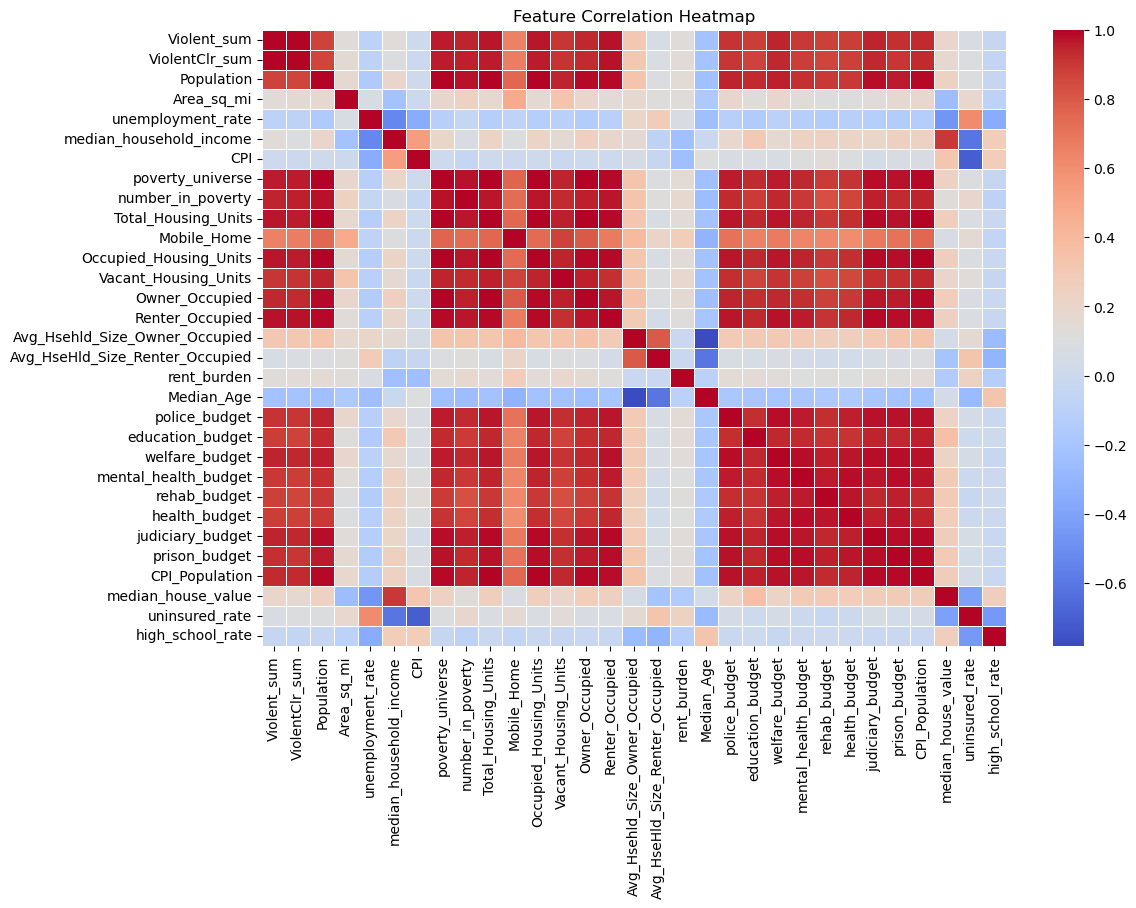

In [378]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

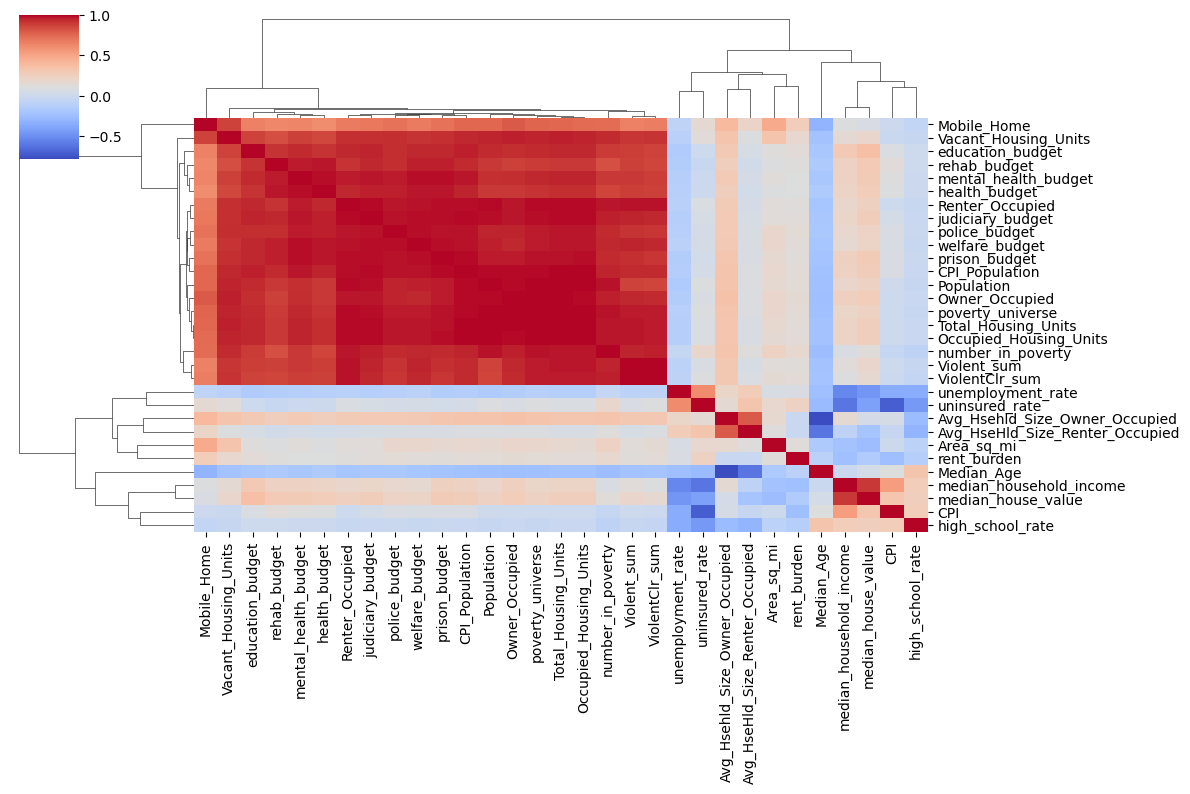

In [379]:
sns.clustermap(correlation_matrix, cmap="coolwarm", figsize=(12, 8))
plt.show()

## Computing rates

In [151]:
def compute_crime_rate(df):
    """
    Computes the crime rate as Total Crimes per 1,000 people and adds it to the dataset.
    Parameters:
        data (pd.DataFrame): The input dataset.
    Returns:
        pd.DataFrame: The dataset with the crime rate as the target column.
    """
    data = df.copy()
    if "Violent_sum" in data.columns and "Population" in data.columns:
        data["crime_rate"] = data["Violent_sum"] / data["Population"]
        return data

    raise ValueError(
        "Columns 'Violent_sum' and 'Population' are required to compute the crime rate."
    )


def compute_clearance_rate(df):
    """
    Computes the clearance rate as ViolentClr_sum / Violent_sum.
    """
    data = df.copy()
    if "ViolentClr_sum" in data.columns and "Violent_sum" in data.columns:
        data["clearance_rate"] = data["ViolentClr_sum"] / data["Violent_sum"]
        # print("Computed .... clearance_rate")
    else:
        raise ValueError(
            "Columns 'ViolentClr_sum' and 'Violent_sum' are required for clearance rate."
        )
    return data


# Feature Function: Compute Population Density
def compute_population_density(df):
    """
    Computes the population density as Population / Area_sq_mi.
    """
    data = df.copy()
    if "Population" in data.columns and "Area_sq_mi" in data.columns:
        data["population_density"] = data["Population"] / data["Area_sq_mi"]
    else:
        raise ValueError(
            "Columns 'Population' and 'Area_sq_mi' are required for population density."
        )
    return data


# Dynamically Add Adjusted Expenditure Columns


def add_adjusted_expenditures(df):
    """
    Adjusts expenditure columns by CPI_Population.
    Parameters:
        data (pd.DataFrame): The input dataset.
    Returns:
        pd.DataFrame: The dataset with adjusted expenditure columns.
    """
    data = df.copy()
    
    if all(
        col in data.columns
        for col in [
            "police_budget",
            "education_budget",
            "welfare_budget",
            "mental_health_budget",
            "rehab_budget",
            "health_budget",
            "judiciary_budget",
            "prison_budget",
            'Population',
            "CPI",
        ]
    ):
        data['CPI_Population'] = data["CPI"] * data["Population"]
        data["adj_police_budget"] = data["police_budget"] / data["CPI_Population"]
        data["adj_education_budget"] = data["education_budget"] / data["CPI_Population"]
        data["adj_welfare_budget"] = data["welfare_budget"] / data["CPI_Population"]
        data["adj_mental_health_budget"] = (
            data["mental_health_budget"] / data["CPI_Population"]
        )
        data["adj_rehab_budget"] = data["rehab_budget"] / data["CPI_Population"]
        data["adj_health_budget"] = data["health_budget"] / data["CPI_Population"]
        data["adj_judiciary_budget"] = data["judiciary_budget"] / data["CPI_Population"]
        data["adj_prison_budget"] = data["prison_budget"] / data["CPI_Population"]

        data["social_vs_security"] = (
            data["adj_education_budget"]
            + data["adj_welfare_budget"]
            + data["adj_health_budget"]
        ) / (
            data["adj_police_budget"]
            + data["adj_judiciary_budget"]
            + data["adj_prison_budget"]
        )
        data["security_vs_social"] = (
            data["adj_police_budget"]
            + data["adj_judiciary_budget"]
            + data["adj_prison_budget"]
        ) / (
            data["adj_education_budget"]
            + data["adj_welfare_budget"]
            + data["adj_health_budget"]
        )
    else:
        raise ValueError("Required columns for adjusted_expenditures are missing.")

    return data


# Feature Function: Adjusted Income
def compute_adjusted_income(df):
    """
    Computes adjusted income as median household income divided by CPI.
    """
    data = df.copy()
    if "median_household_income" in data.columns and "CPI" in data.columns:
        data["adjusted_income"] = data["median_household_income"] / data["CPI"]
    else:
        raise ValueError(
            "Columns 'median_household_income' and 'CPI' are required for adjusted income."
        )
    return data


# Feature Function: House Affordability
def compute_house_affordability(df):
    """
    Computes house affordability as median house value divided by median household income.
    """
    data = df.copy()
    if (
        "median_house_value" in data.columns
        and "median_household_income" in data.columns
    ):
        data["house_affordability"] = (
            data["median_house_value"] / data["median_household_income"]
        )
    else:
        raise ValueError(
            "Columns 'median_house_value' and 'median_household_income' are required for house affordability."
        )
    return data


# Feature Function: Home Ownership Rate
def compute_home_ownership_rate(df):
    """
    Computes home ownership rate as Owner_Occupied divided by Occupied_Housing_Units.
    """
    data = df.copy()
    if "Owner_Occupied" in data.columns and "Occupied_Housing_Units" in data.columns:
        data["home_ownership_rate"] = (
            data["Owner_Occupied"] / data["Occupied_Housing_Units"]
        )
    else:
        raise ValueError(
            "Columns 'Owner_Occupied' and 'Occupied_Housing_Units' are required for home ownership rate."
        )
    return data


# Feature Function: Total Persons and Household Metrics
def compute_persons_and_household_metrics(df):
    """
    Computes total persons, total persons for owners/renters, and persons per household.
    """
    data = df.copy()
    if all(
        col in data.columns
        for col in [
            "Vacant_Housing_Units",
            "Total_Housing_Units",
            "Owner_Occupied",
            "Avg_Hsehld_Size_Owner_Occupied",
            "Renter_Occupied",
            "Avg_HseHld_Size_Renter_Occupied",
            "Occupied_Housing_Units",
            "Mobile_Home",
        ]
    ):
        data["vacancy_rate"] = (
            data["Vacant_Housing_Units"] / data["Total_Housing_Units"]
        )
        data["Total_Persons_Owner"] = (
            data["Owner_Occupied"] * data["Avg_Hsehld_Size_Owner_Occupied"]
        )
        data["Total_Persons_Renter"] = (
            data["Renter_Occupied"] * data["Avg_HseHld_Size_Renter_Occupied"]
        )
        data["Total_Persons"] = (
            data["Total_Persons_Owner"] + data["Total_Persons_Renter"]
        )
        data["Number_of_Persons_per_HseHld"] = (
            data["Total_Persons"] / data["Occupied_Housing_Units"]
        )
        data["renter_ratio"] = data["Total_Persons_Renter"] / data["Total_Persons"]
        data["mobile_home_ratio"] = data["Mobile_Home"] / data["Total_Housing_Units"]
    else:
        raise ValueError(
            "Required columns for total persons or household metrics are missing."
        )
    return data

In [152]:
features_funcs = [
    compute_crime_rate,
    compute_clearance_rate,
    compute_population_density,
    add_adjusted_expenditures,
    compute_adjusted_income,
    compute_house_affordability,
    compute_home_ownership_rate,
    #compute_mobile_home_ratio,
    compute_persons_and_household_metrics,
]

In [153]:
def apply_features(df, funcs):
    data = df.copy()

    for feature_func in funcs:
        data = feature_func(data)
    return data

In [154]:
test_df = apply_features(df=dff, funcs=features_funcs)

In [155]:
feature_0 = [
    'Population',
    'clearance_rate',
    'population_density',
    'unemployment_rate',
    'adjusted_income',
    'poverty_rate',
    'rent_burden',
    'home_ownership_rate',
    'mobile_home_ratio',
    'vacancy_rate',
    'Number_of_Persons_per_HseHld',
    'renter_ratio',
    'Median_Age',
    'adj_police_budget',
    'adj_education_budget',
    'adj_welfare_budget',
    'adj_mental_health_budget',
    'adj_rehab_budget',
    'adj_health_budget',
    'adj_judiciary_budget',
    'adj_prison_budget',
    'house_affordability',
    'uninsured_rate',
    'high_school_rate',
    'dropout_rate',
    'public_school_rate',
    "social_vs_security",
    "security_vs_social",
    'adherent_rate',
    'religion_diversity']
feature_cat=['Category_Rural', 'Category_Suburban', 'Category_Urban']

In [156]:
new_test_df = test_df[["County", "Year", "crime_rate"] + feature_0 + feature_cat]
# new_test_df=new_test_df.set_index(['County', 'Year'])
new_test_df.head()

,County,Year,crime_rate,Population,clearance_rate,population_density,unemployment_rate,adjusted_income,poverty_rate,rent_burden,...,high_school_rate,dropout_rate,public_school_rate,social_vs_security,security_vs_social,adherent_rate,religion_diversity,Category_Rural,Category_Suburban,Category_Urban
0,Alameda,1985,0.009809,1185500,0.466890,1606.368564,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
1,Alameda,1986,0.010353,1206900,0.445778,1635.365854,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
2,Alameda,1987,0.009588,1220600,0.538580,1653.929539,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
3,Alameda,1988,0.008825,1242300,0.520660,1683.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
4,Alameda,1989,0.008375,1261200,0.497018,1708.943089,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1


In [157]:
new_test_df.columns

Index(['County', 'Year', 'crime_rate', 'Population', 'clearance_rate',
       'population_density', 'unemployment_rate', 'adjusted_income',
       'poverty_rate', 'rent_burden', 'home_ownership_rate',
       'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld',
       'renter_ratio', 'Median_Age', 'adj_police_budget',
       'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability',
       'uninsured_rate', 'high_school_rate', 'dropout_rate',
       'public_school_rate', 'social_vs_security', 'security_vs_social',
       'adherent_rate', 'religion_diversity', 'Category_Rural',
       'Category_Suburban', 'Category_Urban'],
      dtype='object')

In [158]:
new_test_df = new_test_df.set_index(["County", "Year"])

In [159]:
new_test_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2262 entries, ('Alameda', 1985) to ('Yuba', 2023)
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   crime_rate                    2262 non-null   float64
 1   Population                    2262 non-null   int64  
 2   clearance_rate                2262 non-null   float64
 3   population_density            2262 non-null   float64
 4   unemployment_rate             1914 non-null   float64
 5   adjusted_income               928 non-null    float64
 6   poverty_rate                  870 non-null    float64
 7   rent_burden                   812 non-null    float64
 8   home_ownership_rate           812 non-null    float64
 9   mobile_home_ratio             812 non-null    float64
 10  vacancy_rate                  812 non-null    float64
 11  Number_of_Persons_per_HseHld  812 non-null    float64
 12  renter_ratio                  812 no

In [160]:


def fill_missing_with_linear_regression(group):
    """
    For a single county (group), fit a simple linear regression model
    Year vs. each numeric column. Use that model to fill missing values.
    """
    # Sort by Year for clarity
    group = group.sort_index(level='Year')
    
    # Iterate over each column
    for col in group.columns:
        # Only process numeric columns
        if pd.api.types.is_numeric_dtype(group[col]):
            # Extract the known data points (drop missing)
            valid_data = group[col].dropna()
            
            # If there aren't at least two valid points, we can't fit a regression
            if len(valid_data) < 2:
                continue
            
            # Prepare X (Year) and y (column values)
            X = valid_data.index.get_level_values('Year').values.reshape(-1, 1)
            y = valid_data.values
            
            # Fit the linear regression model
            model = LinearRegression().fit(X, y)
            
            # Predict for all years in this county
            X_all = group.index.get_level_values('Year').values.reshape(-1, 1)
            y_pred = model.predict(X_all)
            
            # Fill only missing values with the predictions
            missing_mask = group[col].isna()
            group.loc[missing_mask, col] = y_pred[missing_mask]
        else:
            print(f"Skipping non-numeric column: {col}")
    
    return group

In [161]:
# 1. Copy your original DataFrame and set a MultiIndex
df = new_test_df.copy()
#df = df.set_index(['County', 'Year'])
# 2. Group by County and apply the regression-based filling
df_reg_filled = (
    df.groupby(level='County', group_keys=False)
      .apply(fill_missing_with_linear_regression)
)

df_reg_filled.head()

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985           5.890887       198.249497     20.616190    49.471868   
        1986           5.887444       202.918528     20.301905    49.215165   
        1987           5.884002       207.587558     19.987619    48.958462   
        1988           5.880559       212.256589     19.673333    48.701758   
        1989           5.877117       216.925620     19.359048    48.445055   

              home_ownership_rate  mobile_home_ratio  ...  high_school_rate  \
County  Year                                          ...                     
Alameda 1985             0.541511           0.013777  ...         53.839341   
        1986             0.541334           0.013726  ...         54.807253   
        1987             0.541157           0.013674  ...         55.775165   
        1988             0.540979           0.013623  ...         56.743077   
        1989             0.540802           0.013572  ...         57.710989   

              dropout_rate  public_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985      0.038731            0.928594            2.132060   
        1986      0.038225            0.927948            2.135405   
        1987      0.037719            0.927301            2.138751   
        1988      0.037213            0.926655            2.142097   
        1989      0.036707            0.926009            2.145442   

              security_vs_social  adherent_rate  religion_diversity  \
County  Year                                                          
Alameda 1985            0.394342       0.167093            2.195604   
        1986            0.396383       0.173917            2.248352   
        1987            0.398423       0.180741            2.301099   
        1988            0.400463       0.187565            2.353846   
        1989            0.402504       0.194389            2.406593   

              Category_Rural  Category_Suburban  Category_Urban  
County  Year                                                     
Alameda 1985               0                  0               1  
        1986               0                  0               1  
        1987               0                  0               1  
        1988               0                  0               1  
        1989               0                  0               1  

[5 rows x 34 columns]

In [131]:
df_reg_filled.columns

Index(['crime_rate', 'Population', 'clearance_rate', 'population_density',
       'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden',
       'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate',
       'Number_of_Persons_per_HseHld', 'renter_ratio', 'Median_Age',
       'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability',
       'uninsured_rate', 'high_school_rate', 'dropout_rate',
       'public_school_rate', 'social_vs_security', 'security_vs_social',
       'adherent_rate', 'religion_diversity', 'Category_Rural',
       'Category_Suburban', 'Category_Urban'],
      dtype='object')

In [132]:
df_reg_filled.columns[df_reg_filled.isnull().any()].tolist()

['adj_police_budget',
 'adj_education_budget',
 'adj_welfare_budget',
 'adj_mental_health_budget',
 'adj_rehab_budget',
 'adj_health_budget',
 'adj_judiciary_budget',
 'adj_prison_budget',
 'house_affordability',
 'social_vs_security',
 'security_vs_social',
 'adherent_rate',
 'religion_diversity']

In [162]:
df_reg_filled.isna().sum()

crime_rate                       0
Population                       0
clearance_rate                   0
population_density               0
unemployment_rate                0
adjusted_income                  0
poverty_rate                     0
rent_burden                      0
home_ownership_rate              0
mobile_home_ratio                0
vacancy_rate                     0
Number_of_Persons_per_HseHld     0
renter_ratio                     0
Median_Age                       0
adj_police_budget               39
adj_education_budget            39
adj_welfare_budget              39
adj_mental_health_budget        77
adj_rehab_budget                77
adj_health_budget               39
adj_judiciary_budget            39
adj_prison_budget               39
house_affordability             39
uninsured_rate                   0
high_school_rate                 0
dropout_rate                     0
public_school_rate               0
social_vs_security              39
security_vs_social  

In [163]:
df_reg_filled.shape

(2262, 34)

In [164]:
df_reg_filled.dropna().shape

(2030, 34)

In [165]:
# Save to .xlsx file
Final_2010_2023 = df_reg_filled.dropna().reset_index()
Final_2010_2023.to_excel(
    "../dataset/Features_crime_data_2010-2023.xlsx", sheet_name="Crime_Data", index=False
)

# Save to .xlsx file
Final_1985_2023 = new_test_df.reset_index()
Final_1985_2023.to_excel(
    "../dataset/Features_crime_data_1985-2023.xlsx", sheet_name="Crime_Data", index=False
)